In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm


In [2]:
data_path = "./data/Activity recognition exp/"
model_path = "./models/"
freq = "5ms"
freq_number = 5
window_size = 2000
seconds = 2

In [306]:
phone_acc = pd.read_csv(data_path + "Phones_accelerometer.csv")
phone_gyro = pd.read_csv(data_path + "Phones_gyroscope.csv")
watch_acc = pd.read_csv(data_path + "Watch_accelerometer.csv")
watch_gyro = pd.read_csv(data_path + "Watch_gyroscope.csv")

# Temporal alignment

I discovered that some recordings are done with more than just a smartwatch or smartphone (e.g. with 2 smartwatch together). This will be managed in next sections

In [ ]:
from tqdm import tqdm
import numpy as np

phone_acc_df_list = {}
phone_gyro_df_list = {}
watch_acc_df_list = {}
watch_gyro_df_list = {}

min_arrival_time = min(phone_acc.Arrival_Time)
max_arrival_time = max(phone_acc.Arrival_Time)

phone_acc_df = pd.DataFrame(columns=["Arrival_Time", "Device", "User", "x", "y", "z", "gt", "window_start"])
phone_gyro_df = pd.DataFrame(columns=["Arrival_Time", "Device", "User", "x", "y", "z", "gt", "window_start"])
watch_acc_df = pd.DataFrame(columns=["Arrival_Time", "Device", "User", "x", "y", "z", "gt", "window_start"])
watch_gyro_df = pd.DataFrame(columns=["Arrival_Time", "Device", "User", "x", "y", "z", "gt", "window_start"])

# Iterate over the range using a counter
counter = 0
for t in tqdm(range(min_arrival_time, max_arrival_time, window_size)):

    #taking data inside a temporal window of 2 seconds
    phone_acc_t = phone_acc[(phone_acc.Arrival_Time >= t) & (phone_acc.Arrival_Time < t + window_size)][["Arrival_Time", "Device", "User", "x", "y", "z", "gt"]]
    phone_gyro_t = phone_gyro[(phone_gyro.Arrival_Time >= t) & (phone_gyro.Arrival_Time < t + window_size)][["Arrival_Time", "Device", "User", "x", "y", "z", "gt"]]
    watch_acc_t = watch_acc[(watch_acc.Arrival_Time >= t) & (watch_acc.Arrival_Time < t + window_size)][["Arrival_Time", "Device", "User", "x", "y", "z", "gt"]]
    watch_gyro_t = watch_gyro[(watch_gyro.Arrival_Time >= t) & (watch_gyro.Arrival_Time < t + window_size)][["Arrival_Time", "Device", "User", "x", "y", "z", "gt"]]
    
    #adding temporal windows only if we have all sensors data
    if not watch_gyro_t.empty and not watch_acc_t.empty and not phone_gyro_t.empty and not phone_acc_t.empty:
        phone_acc_t['window_start'] = t
        phone_gyro_t['window_start'] = t
        watch_acc_t['window_start'] = t
        watch_gyro_t['window_start'] = t

        #I use a dictionary to speed up the process (instead of appending dataframes, direct access is faster)
        phone_acc_df_list[counter] = phone_acc_t
        phone_gyro_df_list[counter] = phone_gyro_t
        watch_acc_df_list[counter] = watch_acc_t
        watch_gyro_df_list[counter] = watch_gyro_t
        
        counter += 1

In [ ]:
# Concatenate the dataframes outside the loop
phone_acc_df = pd.concat([phone_acc_df_list[i] for i in range(len(phone_acc_df_list))], ignore_index=True)
phone_gyro_df = pd.concat([phone_gyro_df_list[i] for i in range(len(phone_gyro_df_list))], ignore_index=True)
watch_acc_df = pd.concat([watch_acc_df_list[i] for i in range(len(watch_acc_df_list))], ignore_index=True)
watch_gyro_df = pd.concat([watch_gyro_df_list[i] for i in range(len(watch_gyro_df_list))], ignore_index=True)

In [ ]:
phone_acc_df.to_csv(data_path + "phone_acc_df_2s.csv", index=False)
phone_gyro_df.to_csv(data_path + "phone_gyro_df_2s.csv", index=False)
watch_acc_df.to_csv(data_path + "watch_acc_df_2s.csv", index=False)
watch_gyro_df.to_csv(data_path + "watch_gyro_df_2s.csv", index=False)

# Handling multiple devices in the same experiment

Since in a single temporal window, with the same user and the same label we have multiple smartphones and/or multiple smartwatch, I will create two distintinct datasets.

- The first Dataset will contain all the devices data, for each temporal window, permutation of devices data are computed in order to create multiple temporal instances where each instance contain the combination of data retrived from a single smartphone and single smartwatch. This dataset will be used to train the pretext task with SimCLR

- The second Dataset will contain values only from a single smartphone and a single smartwatch that are chosen based on the number of samples contained in the raw dataset. This set of data will be used to train the baseline model and to fine tune the downstream task

## Performing permutation of devices data for each temporal window

In [3]:
phone_acc_df = pd.read_csv(data_path + "phone_acc_df_2s.csv", low_memory = False)
phone_gyro_df = pd.read_csv(data_path + "phone_gyro_df_2s.csv", low_memory = False)
watch_acc_df = pd.read_csv(data_path + "watch_acc_df_2s.csv", low_memory = False)
watch_gyro_df = pd.read_csv(data_path + "watch_gyro_df_2s.csv", low_memory = False)

In [4]:
phone_acc_group = phone_acc_df.groupby('window_start')
phone_gyro_group = phone_gyro_df.groupby('window_start')
watch_acc_group = watch_acc_df.groupby('window_start')
watch_gyro_group = watch_gyro_df.groupby('window_start')

tmp_phone_acc = {}
tmp_phone_gyro = {}
tmp_watch_acc = {}
tmp_watch_gyro = {}

cont = 0
for window, phone_acc in tqdm(phone_acc_group):
    phone_gyro = phone_gyro_group.get_group(window)
    watch_acc = watch_acc_group.get_group(window)
    watch_gyro = watch_gyro_group.get_group(window)

    #taking only the devices that are present in all the sensors data (some devices do not have the gyrscope sensor like the samsungold)
    phone_devices = set(phone_acc.Device.unique()).intersection(set(phone_gyro.Device.unique()))
    watch_devices = set(watch_acc.Device.unique()).intersection(set(watch_gyro.Device.unique()))
    print(phone_devices, watch_devices, phone_gyro.User.unique(), watch_gyro.User.unique(), phone_acc.User.unique(), watch_acc.User.unique())
    break

    for phone in phone_devices:
        for watch in watch_devices:
            tmp_phone_acc[cont] = phone_acc[phone_acc.Device == phone].copy()
            tmp_phone_gyro[cont] = phone_gyro[phone_gyro.Device == phone].copy()
            tmp_watch_acc[cont] = watch_acc[watch_acc.Device == watch].copy()
            tmp_watch_gyro[cont] = watch_gyro[watch_gyro.Device == watch].copy()

            tmp_phone_acc[cont]['window_index'] = np.repeat(cont, len(tmp_phone_acc[cont]))
            tmp_phone_gyro[cont]['window_index'] = np.repeat(cont, len(tmp_phone_gyro[cont]))
            tmp_watch_acc[cont]['window_index'] = np.repeat(cont, len(tmp_watch_acc[cont]))
            tmp_watch_gyro[cont]['window_index'] = np.repeat(cont, len(tmp_watch_gyro[cont]))
            cont += 1

  0%|          | 0/7323 [00:00<?, ?it/s]

{'s3mini_1', 's3mini_2', 'nexus4_1', 's3_2', 's3_1', 'nexus4_2'} {'gear_2'} ['g'] ['g'] ['g'] ['g']


In [ ]:
phone_acc_df = pd.concat([tmp_phone_acc[i] for i in range(len(tmp_phone_acc))], ignore_index=True)
phone_gyro_df = pd.concat([tmp_phone_gyro[i] for i in range(len(tmp_phone_gyro))], ignore_index=True)
watch_acc_df = pd.concat([tmp_watch_acc[i] for i in range(len(tmp_watch_acc))], ignore_index=True)
watch_gyro_df = pd.concat([tmp_watch_gyro[i] for i in range(len(tmp_watch_gyro))], ignore_index=True)

In [ ]:
phone_acc_df

,Arrival_Time,Device,User,x,y,z,gt,window_start,window_index
0,1424686739870,s3mini_2,g,-2.497152,1.118092,9.175778,stand,1424686738639,0
1,1424686739871,s3mini_2,g,-2.725799,1.007959,9.084799,stand,1424686738639,0
2,1424686739871,s3mini_2,g,-2.711433,0.944513,9.011775,stand,1424686738639,0
3,1424686739871,s3mini_2,g,-2.814384,1.029507,9.133880,stand,1424686738639,0
4,1424686739871,s3mini_2,g,-2.871845,1.037886,9.137471,stand,1424686738639,0
...,...,...,...,...,...,...,...,...,...
11809719,1424789460605,nexus4_2,e,1.241409,-0.249359,11.823532,bike,1424789458639,47267
11809720,1424789460610,nexus4_2,e,0.980759,-0.193420,11.739029,bike,1424789458639,47267
11809721,1424789460615,nexus4_2,e,0.743912,-0.225555,11.681900,bike,1424789458639,47267
11809722,1424789460620,nexus4_2,e,0.513016,-0.257690,11.446243,bike,1424789458639,47267


In [ ]:
#deleting duplicated arrival times in each window
phone_acc_df.drop_duplicates(subset=['window_index', 'Arrival_Time'], inplace=True)
phone_gyro_df.drop_duplicates(subset=['window_index', 'Arrival_Time'], inplace=True)
watch_acc_df.drop_duplicates(subset=['window_index', 'Arrival_Time'], inplace=True)
watch_gyro_df.drop_duplicates(subset=['window_index', 'Arrival_Time'], inplace=True)

#converting the arrival time and the window start from ms to datetime
watch_acc_df['Arrival_Time'] = pd.to_datetime(watch_acc_df['Arrival_Time'], unit = "ms")
phone_acc_df['Arrival_Time'] = pd.to_datetime(phone_acc_df['Arrival_Time'], unit = "ms")
watch_gyro_df['Arrival_Time'] = pd.to_datetime(watch_gyro_df['Arrival_Time'], unit = "ms")
phone_gyro_df['Arrival_Time'] = pd.to_datetime(phone_gyro_df['Arrival_Time'], unit = "ms")

phone_acc_df['window_start'] = pd.to_datetime(phone_acc_df['window_start'], unit = "ms")
phone_gyro_df['window_start'] = pd.to_datetime(phone_gyro_df['window_start'], unit = "ms")
watch_acc_df['window_start'] = pd.to_datetime(watch_acc_df['window_start'], unit = "ms")
watch_gyro_df['window_start'] = pd.to_datetime(watch_gyro_df['window_start'], unit = "ms")

In [ ]:
watch_acc_df.to_csv(data_path + "watch_acc_df_2s_all_dev.csv", index=False)
watch_gyro_df.to_csv(data_path + "watch_gyro_df_2s_all_dev.csv", index=False)
phone_acc_df.to_csv(data_path + "phone_acc_df_2s_all_dev.csv", index=False)
phone_gyro_df.to_csv(data_path + "phone_gyro_df_2s_all_dev.csv", index=False)

## Creating single device dataset

In [ ]:
phone_acc_df = pd.read_csv(data_path + "phone_acc_df_2s.csv", low_memory = False)
phone_gyro_df = pd.read_csv(data_path + "phone_gyro_df_2s.csv", low_memory = False)
watch_acc_df = pd.read_csv(data_path + "watch_acc_df_2s.csv", low_memory = False)
watch_gyro_df = pd.read_csv(data_path + "watch_gyro_df_2s.csv", low_memory = False)

In [4]:
#taking device names for each window
devices = {}

watch_acc_groups = watch_acc_df.groupby("window_start")
watch_gyro_groups = watch_gyro_df.groupby("window_start")
phone_acc_groups = phone_acc_df.groupby("window_start")
phone_gyro_groups = phone_gyro_df.groupby("window_start")

for window, watch_acc_window in tqdm(watch_acc_groups):
    watch_gyro_window = watch_gyro_groups.get_group(window)
    phone_acc_window = phone_acc_groups.get_group(window)
    phone_gyro_window = phone_gyro_groups.get_group(window)

    if watch_acc_window['User'].unique() == watch_gyro_window['User'].unique() == phone_acc_window['User'].unique() == phone_gyro_window['User'].unique():
        devices[window] = {}
        devices[window]["watch_acc"] = watch_acc_window['Device'].unique()
        devices[window]["watch_gyro"] = watch_gyro_window['Device'].unique()
        devices[window]["phone_acc"] = phone_acc_window['Device'].unique()
        devices[window]["phone_gyro"] = phone_gyro_window['Device'].unique()
    else:
        raise Exception("Multiple user in the same temporal window") #never raised

100%|██████████| 7323/7323 [00:04<00:00, 1690.03it/s]


### counting in how many windows each device appear
This will allow us to select the most used smartphone and smartwatch

In [5]:
phone_acc_devices = {}
phone_gyro_devices = {}
watch_acc_devices = {}
watch_gyro_devices = {}

for window in tqdm(devices):
    for device in devices[window]["phone_acc"]:
        if device in phone_acc_devices:
            phone_acc_devices[device] += 1
        else:
            phone_acc_devices[device] = 1
    for device in devices[window]["phone_gyro"]:
        if device in phone_gyro_devices:
            phone_gyro_devices[device] += 1
        else:
            phone_gyro_devices[device] = 1
    for device in devices[window]["watch_acc"]:
        if device in watch_acc_devices:
            watch_acc_devices[device] += 1
        else:
            watch_acc_devices[device] = 1
    for device in devices[window]["watch_gyro"]:
        if device in watch_gyro_devices:
            watch_gyro_devices[device] += 1
        else:
            watch_gyro_devices[device] = 1


100%|██████████| 7323/7323 [00:00<00:00, 362755.70it/s]


In [6]:
print(phone_acc_devices)
print(phone_gyro_devices)
print(watch_acc_devices)
print(watch_gyro_devices)
print()
print("The most used phone for both accelerometer and gyroscope is the s3mini_1")
print("The most used watch for both accelerometer and gyroscope is the lgwatch_1")

{'nexus4_1': 6764, 'nexus4_2': 6706, 'samsungold_2': 7323, 's3_2': 6818, 'samsungold_1': 7323, 's3_1': 5870, 's3mini_2': 812, 's3mini_1': 6857}
{'nexus4_1': 6765, 's3_2': 6817, 'nexus4_2': 6705, 's3_1': 5871, 's3mini_2': 813, 's3mini_1': 6858}
{'gear_2': 771, 'gear_1': 2660, 'lgwatch_2': 589, 'lgwatch_1': 6265}
{'gear_2': 771, 'gear_1': 2657, 'lgwatch_2': 576, 'lgwatch_1': 6259}

The most used phone for both accelerometer and gyroscope is the s3mini_1
The most used watch for both accelerometer and gyroscope is the lgwatch_1


In [13]:
set(list(watch_acc_devices.keys())).union(set(list(watch_gyro_devices.keys())))

{'gear_1', 'gear_2', 'lgwatch_1', 'lgwatch_2'}

In [ ]:
phone = "s3mini_1"
watch = "lgwatch_1"
count = 0
for window in tqdm(devices):
    if phone in devices[window]["phone_acc"] and watch in devices[window]["watch_acc"]:
        if phone in devices[window]["phone_gyro"] and watch in devices[window]["watch_gyro"]:
            count += 1
print(f"Considering only windows that have the s3mini_1 phone and the lgwatch_1 watch we have {count} windows")

100%|██████████| 7323/7323 [00:00<00:00, 108106.10it/s]

Considering only windows that have the s3mini_1 phone and the lgwatch_1 watch we have 5852 windows


In [ ]:
watch_acc_groups = watch_acc_df.groupby("window_start")
watch_gyro_groups = watch_gyro_df.groupby("window_start")
phone_acc_groups = phone_acc_df.groupby("window_start")
phone_gyro_groups = phone_gyro_df.groupby("window_start")

watch_acc = {}
watch_gyro = {}
phone_acc = {}
phone_gyro = {}

for window, watch_acc_window in tqdm(watch_acc_groups):
    watch_gyro_window = watch_gyro_groups.get_group(window)
    phone_acc_window = phone_acc_groups.get_group(window)
    phone_gyro_window = phone_gyro_groups.get_group(window)

    phone_acc_temp = phone_acc_window[phone_acc_window['Device'] == phone]
    phone_gyro_temp = phone_gyro_window[phone_gyro_window['Device'] == phone]
    watch_acc_temp = watch_acc_window[watch_acc_window['Device'] == watch]
    watch_gyro_temp = watch_gyro_window[watch_gyro_window['Device'] == watch]

    #adding only windows that contains values from all the sensors
    if not (phone_acc_temp.empty or phone_gyro_temp.empty or watch_acc_temp.empty or watch_gyro_temp.empty):

        phone_acc[window] = phone_acc_window[phone_acc_window['Device'] == phone]
        phone_gyro[window] = phone_gyro_window[phone_gyro_window['Device'] == phone]
        watch_acc[window] = watch_acc_window[watch_acc_window['Device'] == watch]
        watch_gyro[window] = watch_gyro_window[watch_gyro_window['Device'] == watch]

watch_acc_df = pd.concat(watch_acc.values())
watch_gyro_df = pd.concat(watch_gyro.values())
phone_acc_df = pd.concat(phone_acc.values())
phone_gyro_df = pd.concat(phone_gyro.values())

100%|██████████| 7323/7323 [00:08<00:00, 835.88it/s] 


In [ ]:
len(phone_gyro_df.groupby("window_start")), len(phone_acc_df.groupby("window_start")), len(watch_acc_df.groupby("window_start")), len(watch_gyro_df.groupby("window_start"))

(5852, 5852, 5852, 5852)

In [ ]:
print(len(watch_acc_df), len(watch_gyro_df), len(phone_acc_df), len(phone_gyro_df))
print("From this numbers i expect to have different frequencies for phone and smartwatch")

2408161 2363664 1026366 1026424
From this numbers i expect to have different frequencies for phone and smartwatch


In [ ]:
#deleting duplicated arrival times in each window
phone_acc_df.drop_duplicates(subset=['window_start', 'Arrival_Time'], inplace=True)
phone_gyro_df.drop_duplicates(subset=['window_start', 'Arrival_Time'], inplace=True)
watch_acc_df.drop_duplicates(subset=['window_start', 'Arrival_Time'], inplace=True)
watch_gyro_df.drop_duplicates(subset=['window_start', 'Arrival_Time'], inplace=True)

In [ ]:
watch_acc_df.to_csv(data_path + "watch_acc_df_2s_single_device.csv", index = False)
watch_gyro_df.to_csv(data_path + "watch_gyro_df_2s_single_device.csv", index = False)
phone_acc_df.to_csv(data_path + "phone_acc_df_2s_single_device.csv", index = False)
phone_gyro_df.to_csv(data_path + "phone_gyro_df_2s_single_device.csv", index = False)

# Estimate median sampling frequency
Here, for each window, we compute the distance between each sample timestamp and then we compute the median of that distances (since is a more robust estimator to eventual outliers) to retrive the median number of millisecond that separates one sample to the next one.

Then we take the mode to estimate the most common frequency among all the devices.

In [5]:
watch_acc_df_all_devices = pd.read_csv(data_path + "watch_acc_df_2s_all_dev.csv", low_memory = False)
watch_gyro_df_all_devices = pd.read_csv(data_path + "watch_gyro_df_2s_all_dev.csv", low_memory = False)
phone_acc_df_all_devices = pd.read_csv(data_path + "phone_acc_df_2s_all_dev.csv", low_memory = False)
phone_gyro_df_all_devices = pd.read_csv(data_path + "phone_gyro_df_2s_all_dev.csv", low_memory = False)

watch_acc_df_all_devices['Arrival_Time'] = pd.to_datetime(watch_acc_df_all_devices['Arrival_Time'])
watch_gyro_df_all_devices['Arrival_Time'] = pd.to_datetime(watch_gyro_df_all_devices['Arrival_Time'])
phone_acc_df_all_devices['Arrival_Time'] = pd.to_datetime(phone_acc_df_all_devices['Arrival_Time'])
phone_gyro_df_all_devices['Arrival_Time'] = pd.to_datetime(phone_gyro_df_all_devices['Arrival_Time'])

#get millis
watch_acc_df_all_devices['Arrival_Time'] = watch_acc_df_all_devices['Arrival_Time'].astype(np.int64).values // 10 ** 6
watch_gyro_df_all_devices['Arrival_Time'] = watch_gyro_df_all_devices['Arrival_Time'].astype(np.int64).values // 10 ** 6
phone_acc_df_all_devices['Arrival_Time'] = phone_acc_df_all_devices['Arrival_Time'].astype(np.int64).values // 10 ** 6
phone_gyro_df_all_devices['Arrival_Time'] = phone_gyro_df_all_devices['Arrival_Time'].astype(np.int64).values // 10 ** 6

watch_acc_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
watch_gyro_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
phone_acc_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
phone_gyro_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)

In [6]:
single_watch_acc_df = pd.read_csv(data_path + "watch_acc_df_2s_single_device.csv")
single_watch_gyro_df = pd.read_csv(data_path + "watch_gyro_df_2s_single_device.csv")
single_phone_acc_df = pd.read_csv(data_path + "phone_acc_df_2s_single_device.csv")
single_phone_gyro_df = pd.read_csv(data_path + "phone_gyro_df_2s_single_device.csv")


single_watch_acc_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_watch_gyro_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_phone_acc_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_phone_gyro_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)


In [ ]:
from scipy.stats import mode
#computing median timestamp delta for each window
def get_freqs(df, index_name):
    freqs = []
    for _, group in tqdm(df.groupby(index_name)):
        arrival_time = group['Arrival_Time'].values
        f = np.array([arrival_time[i] - arrival_time[i-1] for i in range(1, len(arrival_time))])
        freqs.append(np.median(f))

    return freqs

In [ ]:
single_phone_acc_freqs = get_freqs(single_phone_acc_df, index_name="window_start")
single_phone_gyro_freqs = get_freqs(single_phone_gyro_df, index_name="window_start")
single_watch_acc_freqs = get_freqs(single_watch_acc_df, index_name="window_start")
single_watch_gyro_freqs = get_freqs(single_watch_gyro_df, index_name="window_start")

all_phone_acc_freqs = get_freqs(phone_acc_df_all_devices, index_name="window_index")
all_phone_gyro_freqs = get_freqs(phone_gyro_df_all_devices, index_name="window_index")
all_watch_acc_freqs = get_freqs(watch_acc_df_all_devices, index_name="window_index")
all_watch_gyro_freqs = get_freqs(watch_gyro_df_all_devices, index_name="window_index")

In [ ]:
print("Single Device Dataset")
print(f"Phone accelerometer frequency: {1 / (mode(single_phone_acc_freqs, keepdims=True)[0] / 1000)[0]}  Hz")
print(f"Phone gyroscope frequency: {1 / (mode(single_phone_gyro_freqs, keepdims=True)[0] / 1000)[0]}  Hz")
print(f"Watch accelerometer frequency: {1 / (mode(single_watch_acc_freqs, keepdims = True)[0] / 1000)[0]}  Hz")
print(f"Watch gyroscope frequency: {1 / (mode(single_watch_gyro_freqs, keepdims = True)[0] / 1000)[0]}  Hz")
print()
print("All Devices Dataset")
print(f"Phone accelerometer frequency: {1 / (mode(all_phone_acc_freqs, keepdims=True)[0] / 1000)[0]}  Hz")
print(f"Phone gyroscope frequency: {1 / (mode(all_phone_gyro_freqs, keepdims=True)[0] / 1000)[0]}  Hz")
print(f"Watch accelerometer frequency: {1 / (mode(all_watch_acc_freqs, keepdims = True)[0] / 1000)[0]}  Hz")
print(f"Watch gyroscope frequency: {1 / (mode(all_watch_gyro_freqs, keepdims = True)[0] / 1000)[0]}  Hz")

Single Device Dataset
Phone accelerometer frequency: 100.0  Hz
Phone gyroscope frequency: 100.0  Hz
Watch accelerometer frequency: 200.0  Hz
Watch gyroscope frequency: 200.0  Hz

All Devices Dataset
Phone accelerometer frequency: 100.0  Hz
Phone gyroscope frequency: 200.0  Hz
Watch accelerometer frequency: 200.0  Hz
Watch gyroscope frequency: 200.0  Hz


Since Almost all devices show that the most frequent frequency is 200Hz i will resample all the devices at 200Hz, i prefer to keep the same frequency for all the devices to facilitate data management. 

# Data Preprocessing: resampling, smoothing outliers, aligning different sensor samples 

In [7]:
phone_acc_df_all_devices['Arrival_Time'] = pd.to_datetime(phone_acc_df_all_devices['Arrival_Time'], unit = "ms")
phone_gyro_df_all_devices['Arrival_Time'] = pd.to_datetime(phone_gyro_df_all_devices['Arrival_Time'], unit = "ms")
watch_acc_df_all_devices['Arrival_Time'] = pd.to_datetime(watch_acc_df_all_devices['Arrival_Time'], unit = "ms")
watch_gyro_df_all_devices['Arrival_Time'] = pd.to_datetime(watch_gyro_df_all_devices['Arrival_Time'], unit = "ms")

phone_acc_df_all_devices['window_start'] = pd.to_datetime(phone_acc_df_all_devices['window_start'])
phone_gyro_df_all_devices['window_start'] = pd.to_datetime(phone_gyro_df_all_devices['window_start'])
watch_acc_df_all_devices['window_start'] = pd.to_datetime(watch_acc_df_all_devices['window_start'])
watch_gyro_df_all_devices['window_start'] = pd.to_datetime(watch_gyro_df_all_devices['window_start'])

watch_acc_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
watch_gyro_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
phone_acc_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
phone_gyro_df_all_devices.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)

watch_acc_df_all_devices.set_index('Arrival_Time', inplace=True)
watch_gyro_df_all_devices.set_index('Arrival_Time', inplace=True)
phone_acc_df_all_devices.set_index('Arrival_Time', inplace=True)
phone_gyro_df_all_devices.set_index('Arrival_Time', inplace=True)

In [8]:
single_phone_acc_df['Arrival_Time'] = pd.to_datetime(single_phone_acc_df['Arrival_Time'], unit = "ms")
single_phone_gyro_df['Arrival_Time'] = pd.to_datetime(single_phone_gyro_df['Arrival_Time'], unit = "ms")
single_watch_acc_df['Arrival_Time'] = pd.to_datetime(single_watch_acc_df['Arrival_Time'], unit = "ms")
single_watch_gyro_df['Arrival_Time'] = pd.to_datetime(single_watch_gyro_df['Arrival_Time'], unit = "ms")

single_phone_acc_df['window_start'] = pd.to_datetime(single_phone_acc_df['window_start'], unit = "ms")
single_phone_gyro_df['window_start'] = pd.to_datetime(single_phone_gyro_df['window_start'], unit = "ms")
single_watch_acc_df['window_start'] = pd.to_datetime(single_watch_acc_df['window_start'], unit = "ms")
single_watch_gyro_df['window_start'] = pd.to_datetime(single_watch_gyro_df['window_start'], unit = "ms")

single_watch_acc_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_watch_gyro_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_phone_acc_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)
single_phone_gyro_df.sort_values(by=['window_start', 'Arrival_Time'], inplace=True)

single_watch_acc_df.set_index('Arrival_Time', inplace=True)
single_watch_gyro_df.set_index('Arrival_Time', inplace=True)
single_phone_acc_df.set_index('Arrival_Time', inplace=True)
single_phone_gyro_df.set_index('Arrival_Time', inplace=True)

## Note on resampling method used
Using the pandas resample function does not guarantee the desired number of samples for each window. This is because if there are missing values at the start or end of the window, the time difference between samples may not be exactly the desired value (e.g., 2 seconds). To address this issue, we can add the window's start and end timestamps to the index. Additionally, we can pad the values with the same starting and ending values to maintain temporal consistency. This approach ensures that the resampled windows have the exact number of samples required while also maintaining the time proportion.

The following cell contains a playground that allows us to observe the desired resampling behavior.

In [9]:
import numpy as np
from scipy.interpolate import interp1d
from ipywidgets import interact, fixed
# Assuming you have your original data stored in the 'original_data' variable

def resample(window_data, freq, seconds):
    window_start = window_data['window_start'].unique()[0]
    y = window_data[['x', 'y', 'z']].values
    start = window_start.value
    end = start + pd.Timedelta(seconds=seconds).value

    x = np.array([x.value for x in window_data.index])
    if start not in x:
        x = np.hstack([start, x])
        y = np.vstack([y[0], y])
        
    if end not in x:
        x = np.hstack([x, end])
        y = np.vstack([y, y[-1]])

    # Create an instance of interp1d with linear interpolation
    interp_func = interp1d(x, y, kind='linear', fill_value=np.nan, axis = 0)
    resampled_indices = np.linspace(start,  end, num=freq * seconds)
    resampled_data = interp_func(resampled_indices)

    return resampled_indices, resampled_data

def resample_interact(original_data, window_index, freq, seconds):
    window_start = original_data['window_start'].unique()[window_index]
    window_data = original_data[original_data['window_start'] == window_start]
    plt.plot(window_data.index, window_data['x'], label = 'original_data')
    new_x, new_y = resample(window_data, freq, seconds)
    new_x = pd.to_datetime(new_x, unit='ns')
    plt.plot(new_x, new_y[:, 0], label = 'resampled_data')
    plt.legend()


interact(resample_interact, original_data = fixed(single_phone_acc_df), window_index = (0, 5851, 1), freq = (10, 400, 10), seconds = fixed(2))

interactive(children=(IntSlider(value=2925, description='window_index', max=5851), IntSlider(value=200, descri…

<function __main__.resample_interact(original_data, window_index, freq, seconds)>

In [224]:
from scipy import signal

#since with the dataset containing all the devices we can have two temporal windows that starts at the same time (but they will contain different devices), 
#that dataset windows will be indexed with a window counter.
def resample_and_create_unique_dataset(phone_acc_df, phone_gyro_df, watch_acc_df, watch_gyro_df, groupby_name = "window_index", freq=200):
    labels = watch_acc_df['gt'].unique()
    tmp = {}

    watch_acc_groups = watch_acc_df.groupby(groupby_name)
    watch_gyro_groups = watch_gyro_df.groupby(groupby_name)
    phone_acc_groups = phone_acc_df.groupby(groupby_name)
    phone_gyro_groups = phone_gyro_df.groupby(groupby_name)

    watch_acc = {}
    watch_gyro = {}
    phone_acc = {}
    phone_gyro = {}

    seconds = 2
    for window, watch_acc in tqdm(watch_acc_groups):
        df = pd.DataFrame(columns = [groupby_name, 'Arrival_Time', 'User', 'label', 'watch_acc_x', 'watch_acc_y', 'watch_acc_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z', 'phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z'])
        
        watch_gyro = watch_gyro_groups.get_group(window)
        phone_acc = phone_acc_groups.get_group(window)
        phone_gyro = phone_gyro_groups.get_group(window)

        #Try to get the mode, if it throws error it mean that all the values are null therefore we can skip this window
        try:
            gts = pd.DataFrame([watch_acc['gt'].unique(), watch_gyro['gt'].unique(), phone_acc['gt'].unique(), phone_gyro['gt'].unique()]).mode().mode()[0][0] 
            if gts not in labels:
                continue
        except:
            continue
        
        new_index, w_acc_tmp = resample(watch_acc, freq, seconds)
        _, w_gyro_tmp = resample(watch_gyro, freq, seconds)
        _, p_acc_tmp = resample(phone_acc, freq, seconds)
        _, p_gyro_tmp = resample(phone_gyro, freq, seconds)
        


        if not (watch_acc['User'].unique() == watch_gyro['User'].unique() == phone_acc['User'].unique() == phone_gyro['User'].unique()) and len(watch_acc['User'].unique()) == 1:
            continue
        
        df['Arrival_Time'] = new_index
        df['User'] = watch_acc['User'].iloc[0]
        df['label'] = gts
        df[groupby_name] = window

        df[['watch_acc_x', 'watch_acc_y', 'watch_acc_z']] = w_acc_tmp
        df[['watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']] = w_gyro_tmp
        df[['phone_acc_x', 'phone_acc_y', 'phone_acc_z']] = p_acc_tmp
        df[['phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']] = p_gyro_tmp

        #applying median filter to remove outliers
        df[['watch_acc_x', 'watch_acc_y', 'watch_acc_z',
            'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
            'phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x',
            'phone_gyro_y', 'phone_gyro_z']] = df[['watch_acc_x', 'watch_acc_y', 'watch_acc_z',
                                                    'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
                                                    'phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x',
                                                    'phone_gyro_y', 'phone_gyro_z']].rolling(window=10, center = True).median().interpolate() #with a windows of 5 data was still too noisy
        
        #filling nan values created with the median filter
        df = df.fillna(method='bfill').fillna(method='ffill')

        if len(df) != int(seconds * freq):
            raise Exception("Wrong length") #never raised
            
        if df.isnull().values.any():
            continue

        tmp[window] = df
        

    return pd.concat(tmp.values(), ignore_index=True)


In [225]:
freq = 200
single_dataset = resample_and_create_unique_dataset(single_phone_acc_df, single_phone_gyro_df, single_watch_acc_df, single_watch_gyro_df, groupby_name = "window_start", freq = freq)
all_dataset = resample_and_create_unique_dataset(phone_acc_df_all_devices, phone_gyro_df_all_devices, watch_acc_df_all_devices, watch_gyro_df_all_devices, groupby_name = "window_index", freq=freq)

100%|██████████| 47268/47268 [04:25<00:00, 178.13it/s] 


In [299]:
single_dataset

,window_start,Arrival_Time,User,label,watch_acc_x,watch_acc_y,watch_acc_z,watch_gyro_x,watch_gyro_y,watch_gyro_z,phone_acc_x,phone_acc_y,phone_acc_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,2015-02-23 12:12:58.639,2015-02-23 12:12:58.639000064,c,stand,1.027292,-0.288638,-0.139071,-0.069938,-0.022496,0.016966,1.180928,0.287310,0.18405,0.084590,-0.480628,0.677138
1,2015-02-23 12:12:58.639,2015-02-23 12:12:58.644012544,c,stand,1.027292,-0.288638,-0.139071,-0.069938,-0.022496,0.016966,1.180928,0.287310,0.18405,0.084590,-0.480628,0.677138
2,2015-02-23 12:12:58.639,2015-02-23 12:12:58.649025024,c,stand,1.027292,-0.288638,-0.139071,-0.069938,-0.022496,0.016966,1.180928,0.287310,0.18405,0.084590,-0.480628,0.677138
3,2015-02-23 12:12:58.639,2015-02-23 12:12:58.654037760,c,stand,1.027292,-0.288638,-0.139071,-0.069938,-0.022496,0.016966,1.180928,0.287310,0.18405,0.084590,-0.480628,0.677138
4,2015-02-23 12:12:58.639,2015-02-23 12:12:58.659050240,c,stand,1.027292,-0.288638,-0.139071,-0.069938,-0.022496,0.016966,1.180928,0.287310,0.18405,0.084590,-0.480628,0.677138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025995,2015-02-24 14:50:58.639,2015-02-24 14:51:00.618949888,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.878012,-0.321653,0.27324,2.625765,1.135938,0.209494
2025996,2015-02-24 14:50:58.639,2015-02-24 14:51:00.623962368,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.878012,-0.321653,0.27324,2.625765,1.135938,0.209494
2025997,2015-02-24 14:50:58.639,2015-02-24 14:51:00.628975104,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.878012,-0.321653,0.27324,2.625765,1.135938,0.209494
2025998,2015-02-24 14:50:58.639,2015-02-24 14:51:00.633987584,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.878012,-0.321653,0.27324,2.625765,1.135938,0.209494


In [300]:
all_dataset

,window_index,Arrival_Time,User,label,watch_acc_x,watch_acc_y,watch_acc_z,watch_gyro_x,watch_gyro_y,watch_gyro_z,phone_acc_x,phone_acc_y,phone_acc_z,phone_gyro_x,phone_gyro_y,phone_gyro_z
0,0,2015-02-23 10:18:58.639000064,g,stand,0.457663,-1.024213,-1.750780,0.414525,0.568815,0.274453,-0.153219,0.630152,0.210081,0.484804,-0.959325,0.577898
1,0,2015-02-23 10:18:58.644012544,g,stand,0.457663,-1.024213,-1.750780,0.414525,0.568815,0.274453,-0.153219,0.630152,0.210081,0.484804,-0.959325,0.577898
2,0,2015-02-23 10:18:58.649025024,g,stand,0.457663,-1.024213,-1.750780,0.414525,0.568815,0.274453,-0.153219,0.630152,0.210081,0.484804,-0.959325,0.577898
3,0,2015-02-23 10:18:58.654037760,g,stand,0.457663,-1.024213,-1.750780,0.414525,0.568815,0.274453,-0.153219,0.630152,0.210081,0.484804,-0.959325,0.577898
4,0,2015-02-23 10:18:58.659050240,g,stand,0.457663,-1.024213,-1.750780,0.414525,0.568815,0.274453,-0.153219,0.630152,0.210081,0.484804,-0.959325,0.577898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16127995,47267,2015-02-24 14:51:00.618949888,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.626704,-0.247655,1.220682,2.523126,-0.664015,0.573823
16127996,47267,2015-02-24 14:51:00.623962368,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.626704,-0.247655,1.220682,2.523126,-0.664015,0.573823
16127997,47267,2015-02-24 14:51:00.628975104,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.626704,-0.247655,1.220682,2.523126,-0.664015,0.573823
16127998,47267,2015-02-24 14:51:00.633987584,e,bike,0.870897,1.252799,1.765276,0.181679,0.060759,-0.307950,0.626704,-0.247655,1.220682,2.523126,-0.664015,0.573823


In [228]:
single_dataset.isnull().any().any(), all_dataset.isnull().any().any()

(False, False)

In [302]:
freq = "5ms" #previously i saved with this suffix instead of 200 so i stick with this

In [303]:
all_dataset.to_csv(data_path + f"preprocessed_data_all_device_{freq}.csv", index=False)
single_dataset.to_csv(data_path + f"preprocessed_data_single_device_{freq}.csv", index=False)

### Data exploration playgroud
In the following cells the preprocessed and scaled data will be loaded in order to take a look at the result of that phase through ipywidget

In [10]:
freq = "5ms"
train_data = pd.read_csv(data_path + f"preprocessed_data_all_device_{freq}.csv")
test_data = pd.read_csv(data_path + f"preprocessed_data_single_device_{freq}.csv")
train_data.sort_values(by = ['window_index', 'Arrival_Time'], inplace=True)
test_data.sort_values(by = ['window_start', 'Arrival_Time'], inplace=True)

train_data['Arrival_Time'] = pd.to_datetime(train_data['Arrival_Time'])
test_data['Arrival_Time'] = pd.to_datetime(test_data['Arrival_Time'])
test_data['window_start'] = pd.to_datetime(test_data['window_start'])

In [11]:
from sklearn.preprocessing import StandardScaler
from pickle import dump
scaler = StandardScaler()

#I will fit the scaler on the data of all the devices and then transform the data of the single device based on that scaler
train_data[
    ['watch_acc_x', 'watch_acc_y', 'watch_acc_z',
     'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
     'phone_acc_x', 'phone_acc_y', 'phone_acc_z',
     'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']] = scaler.fit_transform(train_data[[
                                                'watch_acc_x', 'watch_acc_y', 'watch_acc_z',
                                                'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
                                                'phone_acc_x', 'phone_acc_y', 'phone_acc_z',
                                                'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']])

test_data[
    ['watch_acc_x', 'watch_acc_y', 'watch_acc_z',
     'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
     'phone_acc_x', 'phone_acc_y', 'phone_acc_z',
     'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']] = scaler.transform(test_data[[
                                                'watch_acc_x', 'watch_acc_y', 'watch_acc_z',
                                                'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z',
                                                'phone_acc_x', 'phone_acc_y', 'phone_acc_z',
                                                'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']])
#saving the scaler.
dump(scaler, open('scaler.pkl', 'wb'))               

In [12]:
from ipywidgets import interact, fixed
windows = len(test_data['window_start'].unique())
print("Number of windows: ", windows)

def plot_data(window_index, f):
    data = test_data[test_data['window_start'] == test_data['window_start'].unique()[window_index]]

    time_slots = []
    for dt in data['Arrival_Time']:
        dt_obj = np.datetime64(dt).astype('datetime64[s]')
        hour = dt_obj.astype('datetime64[h]').item().hour
        minute = dt_obj.astype('datetime64[m]').item().minute
        second = dt_obj.astype('datetime64[s]').item().second
        time_slots.append(str(hour) + ":" + str(minute) + ":" + str(second))
    
    #setting limits for all the 4 graphs in order to have the same scale
    y_lim_down = data[['watch_acc_x', 'watch_acc_y', 'watch_acc_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z', 'phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].min().min() - 0.1
    y_lim_up = data[['watch_acc_x', 'watch_acc_y', 'watch_acc_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z', 'phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].max().max() + 0.1

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.plot(data['Arrival_Time'], data[['phone_acc_x', 'phone_acc_y', 'phone_acc_z']])
    ax1.set_title('phone accelerometer')
    ax1.set_xticks([data['Arrival_Time'].iloc[i] for i in range(0, len(data), f)],[time_slots[i] for i in range(0, len(time_slots), f)])
    ax1.set_ylim(y_lim_down, y_lim_up)


    ax2.plot(data['Arrival_Time'], data[['phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']])
    ax2.set_title('phone gyroscope')
    ax2.set_xticks([data['Arrival_Time'].iloc[i] for i in range(0, len(data), f)],[time_slots[i] for i in range(0, len(time_slots), f)])
    ax2.set_ylim(y_lim_down, y_lim_up)

    ax3.plot(data['Arrival_Time'], data[['watch_acc_x', 'watch_acc_y', 'watch_acc_z']])
    ax3.set_title('watch accelerometer')
    ax3.set_xticks([data['Arrival_Time'].iloc[i] for i in range(0, len(data), f)],[time_slots[i] for i in range(0, len(time_slots), f)])
    ax3.set_ylim(y_lim_down, y_lim_up)

    ax4.plot(data['Arrival_Time'], data[['watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']])
    ax4.set_title('watch gyroscope')
    ax4.set_xticks([data['Arrival_Time'].iloc[i] for i in range(0, len(data), f)],[time_slots[i] for i in range(0, len(time_slots), f)])
    ax4.set_ylim(y_lim_down, y_lim_up)


    print("Activity: ", data['label'].mode()[0])

interact(plot_data, window_index = (0, windows - 1, 1), f = fixed(200))


Number of windows:  5065


interactive(children=(IntSlider(value=2532, description='window_index', max=5064), Output()), _dom_classes=('w…

<function __main__.plot_data(window_index, f)>

Activity:  walk


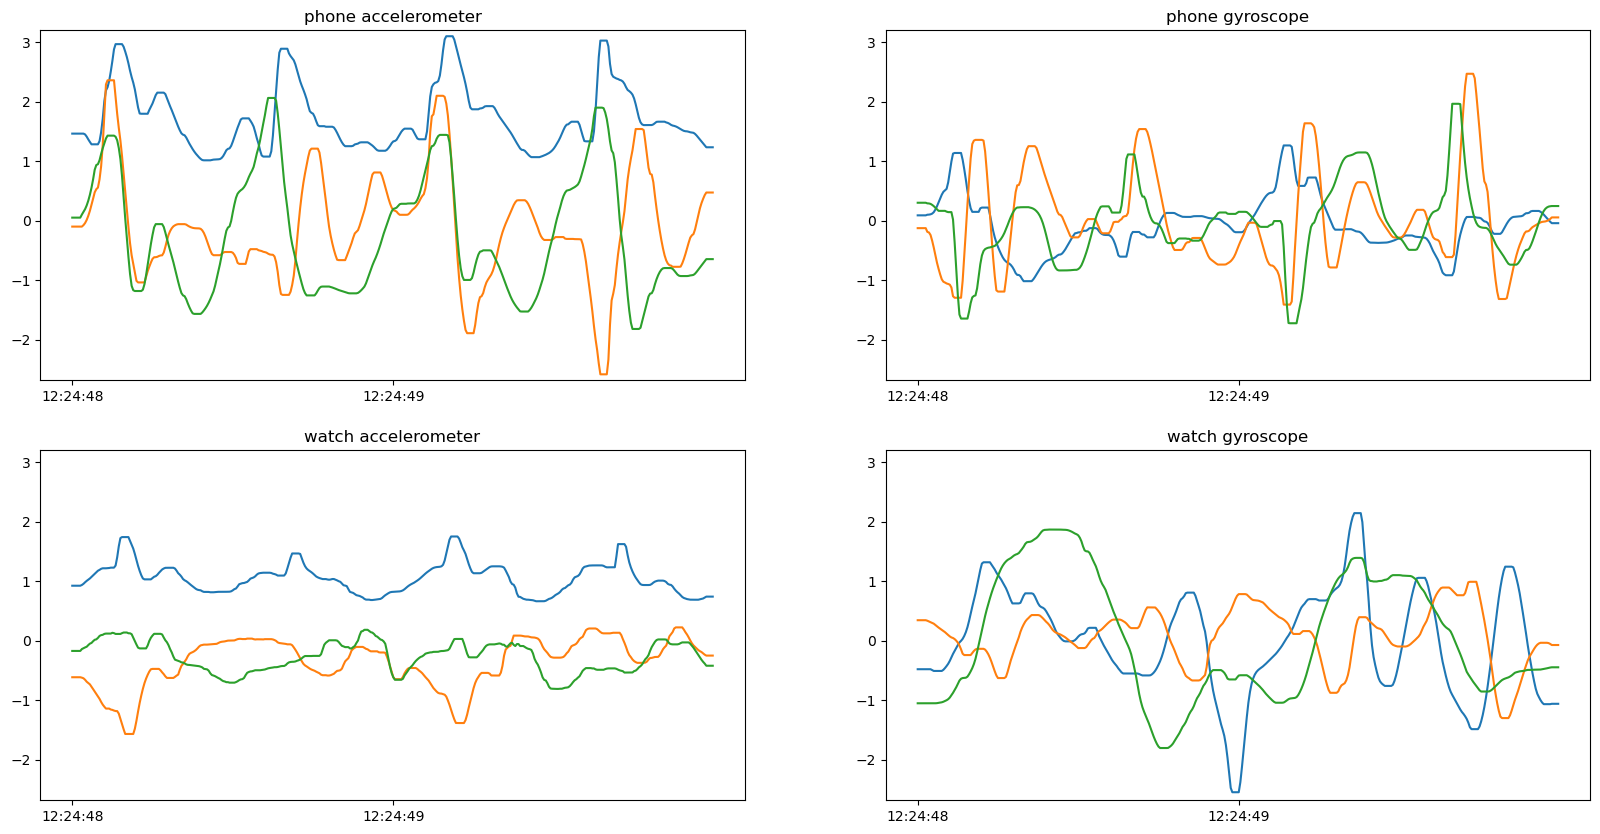

In [17]:
plot_data(300, 200)

# Showing Training Data balance

<Axes: title={'center': 'Data used to train baseline model and downstream task'}, xlabel='User'>

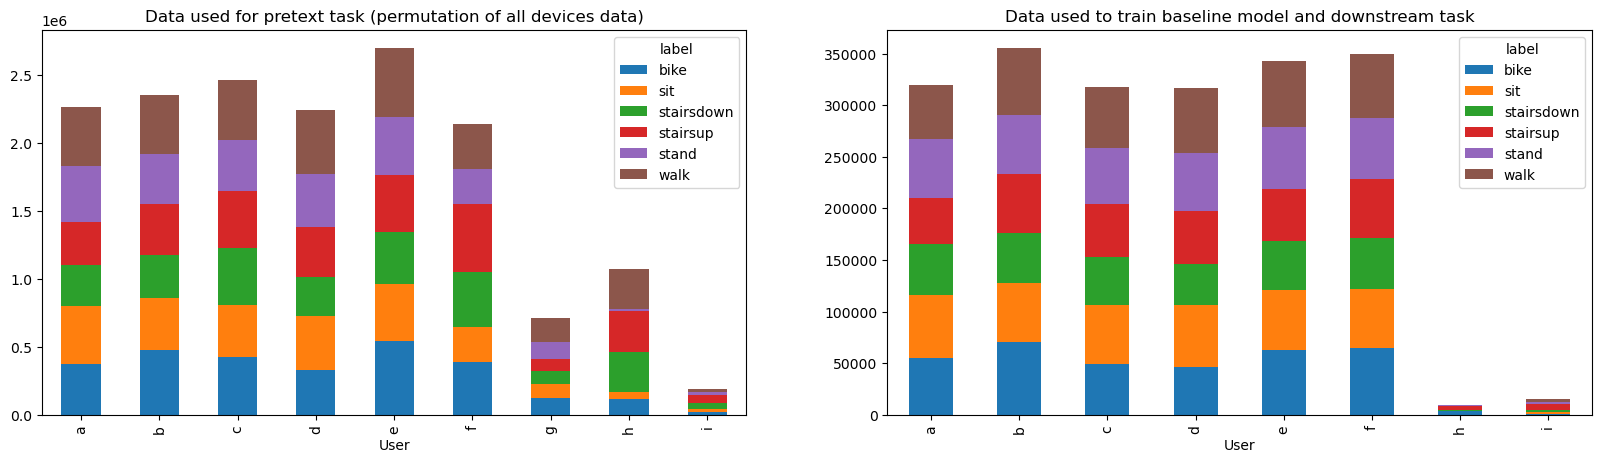

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
train_data.groupby(['User', 'label']).size().unstack().plot(kind='bar', stacked = True, ax=ax1, title='Data used for pretext task (permutation of all devices data)')
test_data.groupby(['User', 'label']).size().unstack().plot(kind='bar', stacked = True, ax=ax2, title='Data used to train baseline model and downstream task')

Here can be noticed that the dataset with the selected devices do not have user g and that user h and i have too few samples even to be resampled. For the data that will be used to train the simclr model i would like to discard all the 3 users g, h, i. User h contains a sufficient amount of data to be resampled but the activity "stand" has too few labels even for that. In order to make things easier i will just drop those users with few samples.

In [15]:
test_data = test_data[test_data['User'] != 'h']
test_data = test_data[test_data['User'] != 'i']
train_data = train_data[train_data['User'] != 'h']
train_data = train_data[train_data['User'] != 'i']
train_data = train_data[train_data['User'] != 'g']

Samples are enough balanced for each activity


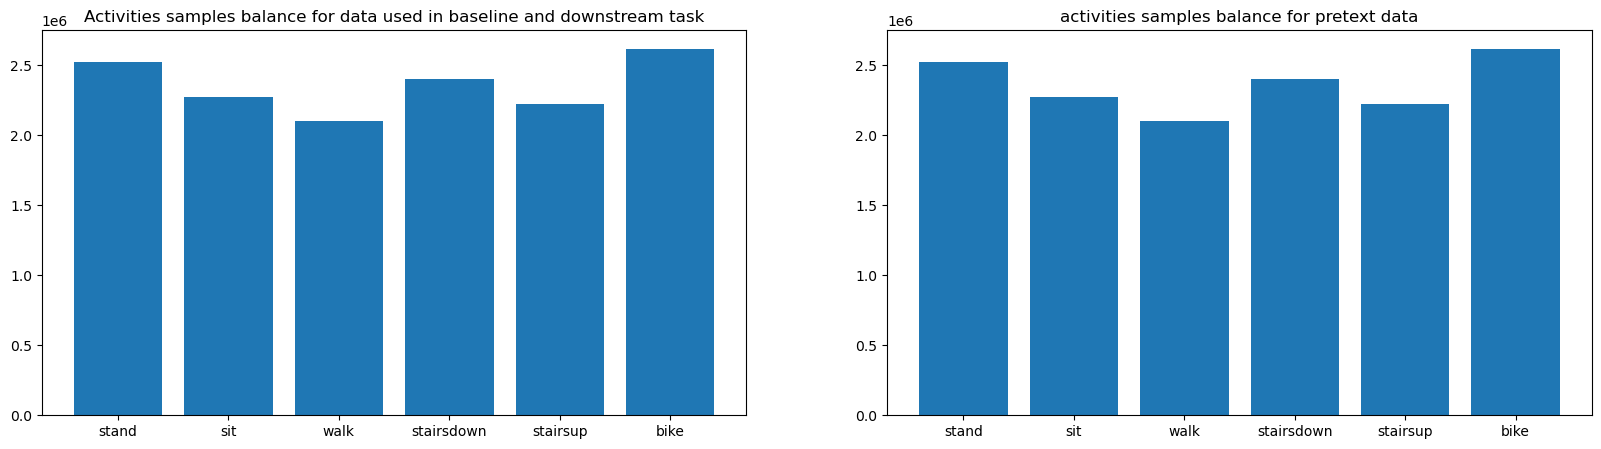

<Figure size 1000x500 with 0 Axes>

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plt.figure(figsize=(10,5))
ax1.bar(test_data['label'].unique(), train_data.groupby(['label']).size())
ax1.set_title("Activities samples balance for data used in baseline and downstream task")

ax2.bar(train_data['label'].unique(), train_data.groupby(['label']).size())
ax2.set_title("activities samples balance for pretext data")

print("Samples are enough balanced for each activity")

# Preparing dataset for leave one subject out training
I want to create windows of 2 seconds, since i want to avoid longer training due to subject retrival in the dataset, i will create a structure that allow me to positionally identify users (in order to avoid search during training).

I know that my dataset is already synchronized with 2 seconds windows that contains exactly 400 values (200Hz) so i can skip the check of the window length (this will be verified by the output shapes)

In [11]:
#the first thing to do is to create a One-Hot encoding of the labels
from sklearn.preprocessing import OneHotEncoder
import pickle
encoder = OneHotEncoder()

train_data['encoded_labels'] = encoder.fit_transform(train_data[['label']]).toarray().tolist()
test_data['encoded_labels'] = encoder.transform(test_data[['label']]).toarray().tolist()

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [12]:
seconds = 2
freq = 200
overlap = 0 #I am not considering overlap since i am not interested in repentine change of activities

In [13]:

pretext_data = [] #train_data[i] will contain i-th user windowed data from the all_devices data
pretext_labels = [] #labels[i] will contain i-th user labels for each window
finetune_data = [] #test_data[i] will contain i-th user windowed data from the single device dataset
finetune_labels = [] #finetune_labels[i] will contain i-th user labels for each window

for subject, data in tqdm(train_data.groupby('User')):
    windows = []
    window_label = []
    data.sort_values(by=['window_index', 'Arrival_Time'], inplace=True)
    for i in range(0, len(data), int(seconds * freq * (1- overlap))):
        window = data.iloc[i:i+seconds * freq][['phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z', 'watch_acc_x', 'watch_acc_y', 'watch_acc_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values
        if len(window) == seconds * freq:
            windows.append(window)
            window_label.append(data['encoded_labels'].iloc[i:i+seconds * freq].mode()[0])
    pretext_data.append(np.array(windows))
    pretext_labels.append(np.array(window_label))
    
for subject, data in tqdm(test_data.groupby('User')):
    windows = []
    window_label = []
    data.sort_values(by=['Arrival_Time'], inplace=True)
    for i in range(0, len(data), int(seconds * freq * (1- overlap))):
        window = data.iloc[i:i+seconds * freq][['phone_acc_x', 'phone_acc_y', 'phone_acc_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z', 'watch_acc_x', 'watch_acc_y', 'watch_acc_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values
        if len(window) == seconds * freq:
            windows.append(window)
            window_label.append(data['encoded_labels'].iloc[i:i+seconds * freq].mode()[0])
    finetune_data.append(np.array(windows))
    finetune_labels.append(np.array(window_label))


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


In [14]:
#freeing some ram before training
del train_data
del test_data

In [15]:
#save pretext_data and finetune_data data (they are lists, cannot use numpy, use pickle)
import pickle
with open('pretext_data.pkl', 'wb') as f:
    pickle.dump(pretext_data, f)
with open('pretext_labels.pkl', 'wb') as f:
    pickle.dump(pretext_labels, f)
with open('finetune_data.pkl', 'wb') as f:
    pickle.dump(finetune_data, f)
with open('finetune_labels.pkl', 'wb') as f:
    pickle.dump(finetune_labels, f)
    

# Train baseline model

In [14]:
#load pretext_data and finetune data 
import pickle
with open('pretext_data.pkl', 'rb') as f:
    pretext_data = pickle.load(f)
with open('pretext_labels.pkl', 'rb') as f:
    pretext_labels = pickle.load(f)
with open('finetune_data.pkl', 'rb') as f:
    finetune_data = pickle.load(f)
with open('finetune_labels.pkl', 'rb') as f:
    finetune_labels = pickle.load(f)

In [15]:
print("Train data shape for each user: ")
for sub, lab in zip(pretext_data, pretext_labels):
    print(sub.shape, lab.shape)

Train data shape for each user: 
(5665, 400, 12) (5665, 6)
(5882, 400, 12) (5882, 6)
(6147, 400, 12) (6147, 6)
(5607, 400, 12) (5607, 6)
(6740, 400, 12) (6740, 6)
(5348, 400, 12) (5348, 6)


In [16]:
print("Test data shape for each user: ")
for sub, lab in zip(finetune_data, finetune_labels):
    print(sub.shape, lab.shape)

Test data shape for each user: 
(799, 400, 12) (799, 6)
(888, 400, 12) (888, 6)
(793, 400, 12) (793, 6)
(792, 400, 12) (792, 6)
(857, 400, 12) (857, 6)
(873, 400, 12) (873, 6)


In [17]:
#disabling info messages for a more clear training visualization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0: all messages are logged, 1: filter out INFO messages, 2: filter out INFO and WARNING messages, 3: filter out INFO, WARNING, and ERROR messages

In [41]:
import tensorflow as tf
from keras.layers import Dense, Conv1D, Flatten, Reshape, Input, LSTM, Concatenate, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization, GlobalAveragePooling1D, Attention
from keras.models import Model
from keras import regularizers
from keras.optimizers.legacy import Adam


def baseline_model(input_shape, num_classes, weight_decay = 1e-3):
    input_layer = Input(input_shape, name="input_layer")

    conv = Conv1D(24, 16, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(input_layer)
    conv = BatchNormalization()(conv)
    #conv = Dropout(0.1)(conv)

    conv = Conv1D(32, 16, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(conv)
    conv = BatchNormalization()(conv)
    #conv = Dropout(0.1)(conv)valid

    conv = Conv1D(64, 8, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(conv)
    conv = BatchNormalization()(conv)

    out = GlobalMaxPooling1D(name = "encoder_output")(conv)

    out = Dense(1024, activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(out)
    out = Dense(num_classes, activation='softmax')(out)

    return Model(inputs=input_layer, outputs=out)

model = baseline_model((seconds * 200, 12), 6)
model.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400, 12)]         0         
                                                                 
 conv1d_138 (Conv1D)         (None, 385, 24)           4632      
                                                                 
 batch_normalization_138 (B  (None, 385, 24)           96        
 atchNormalization)                                              
                                                                 
 conv1d_139 (Conv1D)         (None, 370, 32)           12320     
                                                                 
 batch_normalization_139 (B  (None, 370, 32)           128       
 atchNormalization)                                              
                                                                 
 conv1d_140 (Conv1D)         (None, 363, 64)           164

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf

model_path = "models/"
train_loss = {}
train_acc = {}
val_loss = {}
val_acc = {}

results = {}

#let's be patient and give the model some space!
patience = 10
epochs = 1000
batch_size = 128

#since we are interested in taking the model with the best validation loss and with this data the model tends to overfit
#The selected learning rate is very low but to prevent overfit a large weight decay o 1e-3 is adopted in all the model layers.
#(Other configurations with larger lr or smaller wd tends to overfit a lot more than this)
lr = 0.00001 

for subject in range(len(finetune_data)):
    X_train = np.concatenate([finetune_data[i] for i in range(len(finetune_data)) if i != subject])
    y_train = np.concatenate([finetune_labels[i] for i in range(len(finetune_data)) if i != subject])

    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]

    X_test = finetune_data[subject]
    y_test = finetune_labels[subject]

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='auto', restore_best_weights=True)
    model = baseline_model(X_train.shape[1:], 6)

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], shuffle=True)
    model.save(model_path + f"baseline_model_{subject}")

    #keeping trak of the metrics
    train_loss[subject] = history.history['loss']
    train_acc[subject] = history.history['accuracy']
    val_loss[subject] = history.history['val_loss']
    val_acc[subject] = history.history['val_accuracy']

    #Predict the finetune_data data
    y_pred = model.predict(X_test, verbose=0)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')
    recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')
    f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')

    results[subject] = [precision, recall, f1]

Epoch 1/1000
33/33 [==============================] - 7s 137ms/step - loss: 3.5841 - accuracy: 0.1432 - val_loss: 2.0593 - val_accuracy: 0.0550
Epoch 2/1000
33/33 [==============================] - 2s 73ms/step - loss: 2.4571 - accuracy: 0.2041 - val_loss: 1.9897 - val_accuracy: 0.2350
Epoch 3/1000
33/33 [==============================] - 3s 90ms/step - loss: 1.8727 - accuracy: 0.3531 - val_loss: 1.9144 - val_accuracy: 0.3200
Epoch 4/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.6719 - accuracy: 0.4730 - val_loss: 1.8458 - val_accuracy: 0.3475
Epoch 5/1000
33/33 [==============================] - 3s 81ms/step - loss: 1.5610 - accuracy: 0.5372 - val_loss: 1.7793 - val_accuracy: 0.3600
Epoch 6/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.4708 - accuracy: 0.5998 - val_loss: 1.7168 - val_accuracy: 0.3675
Epoch 7/1000
33/33 [==============================] - 2s 74ms/step - loss: 1.3910 - accuracy: 0.6453 - val_loss: 1.6579 - val_accuracy: 0.397

INFO:tensorflow:Assets written to: models/baseline_model_0/assets


Epoch 1/1000
33/33 [==============================] - 6s 131ms/step - loss: 2.0957 - accuracy: 0.1787 - val_loss: 1.9757 - val_accuracy: 0.2027
Epoch 2/1000
33/33 [==============================] - 2s 75ms/step - loss: 1.7838 - accuracy: 0.3060 - val_loss: 1.9118 - val_accuracy: 0.2410
Epoch 3/1000
33/33 [==============================] - 2s 72ms/step - loss: 1.6538 - accuracy: 0.4011 - val_loss: 1.8446 - val_accuracy: 0.2590
Epoch 4/1000
33/33 [==============================] - 3s 78ms/step - loss: 1.5637 - accuracy: 0.4978 - val_loss: 1.7726 - val_accuracy: 0.3649
Epoch 5/1000
33/33 [==============================] - 2s 74ms/step - loss: 1.4845 - accuracy: 0.5681 - val_loss: 1.6994 - val_accuracy: 0.4955
Epoch 6/1000
33/33 [==============================] - 3s 77ms/step - loss: 1.4159 - accuracy: 0.6485 - val_loss: 1.6329 - val_accuracy: 0.5338
Epoch 7/1000
33/33 [==============================] - 2s 74ms/step - loss: 1.3471 - accuracy: 0.6988 - val_loss: 1.5686 - val_accuracy: 0.572

INFO:tensorflow:Assets written to: models/baseline_model_1/assets


Epoch 1/1000
33/33 [==============================] - 6s 144ms/step - loss: 2.1325 - accuracy: 0.2354 - val_loss: 1.9425 - val_accuracy: 0.2393
Epoch 2/1000
33/33 [==============================] - 3s 86ms/step - loss: 1.7518 - accuracy: 0.3968 - val_loss: 1.8720 - val_accuracy: 0.4433
Epoch 3/1000
33/33 [==============================] - 3s 83ms/step - loss: 1.5840 - accuracy: 0.5293 - val_loss: 1.8167 - val_accuracy: 0.4307
Epoch 4/1000
33/33 [==============================] - 3s 82ms/step - loss: 1.4675 - accuracy: 0.6149 - val_loss: 1.7709 - val_accuracy: 0.4332
Epoch 5/1000
33/33 [==============================] - 2s 69ms/step - loss: 1.3621 - accuracy: 0.6835 - val_loss: 1.7323 - val_accuracy: 0.4559
Epoch 6/1000
33/33 [==============================] - 3s 83ms/step - loss: 1.2702 - accuracy: 0.7230 - val_loss: 1.7157 - val_accuracy: 0.4433
Epoch 7/1000
33/33 [==============================] - 3s 84ms/step - loss: 1.1896 - accuracy: 0.7581 - val_loss: 1.7010 - val_accuracy: 0.448

INFO:tensorflow:Assets written to: models/baseline_model_2/assets


Epoch 1/1000
33/33 [==============================] - 7s 155ms/step - loss: 2.1446 - accuracy: 0.1929 - val_loss: 1.9489 - val_accuracy: 0.3283
Epoch 2/1000
33/33 [==============================] - 3s 89ms/step - loss: 1.8491 - accuracy: 0.3135 - val_loss: 1.8843 - val_accuracy: 0.5227
Epoch 3/1000
33/33 [==============================] - 3s 94ms/step - loss: 1.7178 - accuracy: 0.4162 - val_loss: 1.8156 - val_accuracy: 0.5682
Epoch 4/1000
33/33 [==============================] - 3s 88ms/step - loss: 1.6177 - accuracy: 0.5036 - val_loss: 1.7356 - val_accuracy: 0.6086
Epoch 5/1000
33/33 [==============================] - 3s 89ms/step - loss: 1.5266 - accuracy: 0.5753 - val_loss: 1.6492 - val_accuracy: 0.6692
Epoch 6/1000
33/33 [==============================] - 3s 84ms/step - loss: 1.4384 - accuracy: 0.6508 - val_loss: 1.5572 - val_accuracy: 0.7197
Epoch 7/1000
33/33 [==============================] - 3s 82ms/step - loss: 1.3665 - accuracy: 0.7010 - val_loss: 1.4677 - val_accuracy: 0.760

INFO:tensorflow:Assets written to: models/baseline_model_3/assets


Epoch 1/1000
33/33 [==============================] - 7s 155ms/step - loss: 1.9475 - accuracy: 0.2890 - val_loss: 1.9227 - val_accuracy: 0.1235
Epoch 2/1000
33/33 [==============================] - 3s 93ms/step - loss: 1.7152 - accuracy: 0.4104 - val_loss: 1.8603 - val_accuracy: 0.1282
Epoch 3/1000
33/33 [==============================] - 3s 87ms/step - loss: 1.6020 - accuracy: 0.4965 - val_loss: 1.8061 - val_accuracy: 0.1375
Epoch 4/1000
33/33 [==============================] - 3s 85ms/step - loss: 1.5064 - accuracy: 0.5749 - val_loss: 1.7533 - val_accuracy: 0.1585
Epoch 5/1000
33/33 [==============================] - 3s 82ms/step - loss: 1.4208 - accuracy: 0.6282 - val_loss: 1.7197 - val_accuracy: 0.2611
Epoch 6/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.3442 - accuracy: 0.6697 - val_loss: 1.7115 - val_accuracy: 0.3380
Epoch 7/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.2706 - accuracy: 0.7018 - val_loss: 1.7061 - val_accuracy: 0.352

INFO:tensorflow:Assets written to: models/baseline_model_4/assets


Epoch 1/1000
33/33 [==============================] - 7s 155ms/step - loss: 3.1253 - accuracy: 0.0804 - val_loss: 2.0193 - val_accuracy: 0.2037
Epoch 2/1000
33/33 [==============================] - 3s 89ms/step - loss: 2.2521 - accuracy: 0.2194 - val_loss: 1.9486 - val_accuracy: 0.3432
Epoch 3/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.8670 - accuracy: 0.3313 - val_loss: 1.8776 - val_accuracy: 0.3272
Epoch 4/1000
33/33 [==============================] - 3s 81ms/step - loss: 1.6810 - accuracy: 0.4028 - val_loss: 1.8097 - val_accuracy: 0.4325
Epoch 5/1000
33/33 [==============================] - 2s 75ms/step - loss: 1.5724 - accuracy: 0.5050 - val_loss: 1.7439 - val_accuracy: 0.4805
Epoch 6/1000
33/33 [==============================] - 3s 79ms/step - loss: 1.4780 - accuracy: 0.5970 - val_loss: 1.6781 - val_accuracy: 0.5172
Epoch 7/1000
33/33 [==============================] - 3s 80ms/step - loss: 1.4004 - accuracy: 0.6561 - val_loss: 1.6092 - val_accuracy: 0.537

INFO:tensorflow:Assets written to: models/baseline_model_5/assets


In [45]:
results

{0: [0.5697669151150159, 0.6444869944869945, 0.5813315657229693],
 1: [0.8814964034806713, 0.8442302004477691, 0.832319886885507],
 2: [0.4312769785894086, 0.4558812962283359, 0.4055304946139802],
 3: [0.8943287696736838, 0.8824506253050388, 0.8831173656326005],
 4: [0.6116133822501747, 0.38905385375494067, 0.3403405072231292],
 5: [0.9119977492114897, 0.8561327651859929, 0.8635357743156717]}

In [46]:
average_precision = np.mean([results[i][0] for i in range(len(results))])
average_recall = np.mean([results[i][1] for i in range(len(results))])
average_f1 = np.mean([results[i][2] for i in range(len(results))])

print("Average precision: ", round(average_precision, 3))
print("Average recall: ", round(average_recall, 3))
print("Average f1: ", round(average_f1, 3))

Average precision:  0.717
Average recall:  0.679
Average f1:  0.651


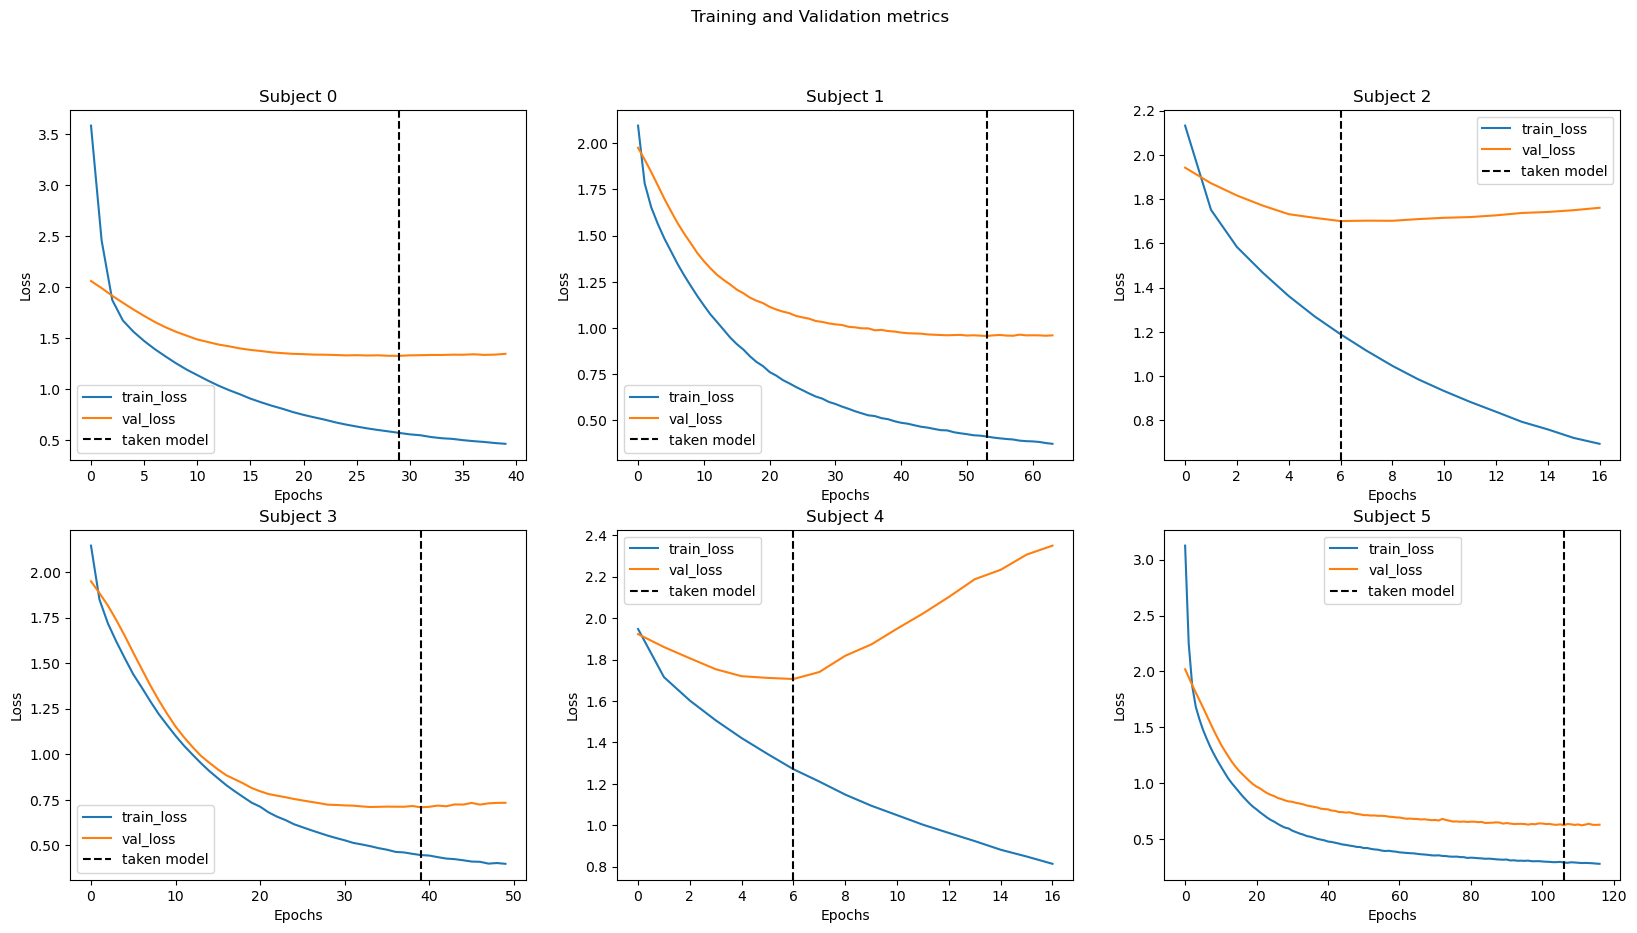

In [47]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Training and Validation metrics')
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(finetune_data)):
    axes[i].plot(train_loss[i], label='train_loss')
    axes[i].plot(val_loss[i], label='val_loss')
    axes[i].set_title(f"Subject {i}")
    #make marker for early stopping
    axes[i].axvline(x=np.argmin(val_loss[i]), c='k', linestyle='--', label = "taken model")
    axes[i].legend()
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')

plt.show()

From the above losses we can see that the model overfits, different hyperparameters and different network architectures were tried. This approach lead to the less-overfitting tried.

Architectures tried:
- Reshaping Data as 2D images where height is window_size, width is represented by the 4 sensors and x,y,z coordinates are the channels. A 3-layer Conv2D network with an MLP of various dimensions. 
- Input --> LSTM, Input --> Conv1D, [Conv1D, LSTM] --> MLP
- Input -->LSTM-->Conv1D-->MLP

Also tried with more "normal" hyperparameters such as a learning rate of 0.001 or 0.0001, much higher overfit even with weight decay.

# Self-supervised learning, SimCLR framework

In [3]:
#load pretext data
import pickle
with open('pretext_data.pkl', 'rb') as f:
    pretext_data = pickle.load(f)
with open('pretext_labels.pkl', 'rb') as f:
    pretext_labels = pickle.load(f)

with open('encoder.pkl', 'rb') as f:
    one_hot_encoder = pickle.load(f)

In [4]:
for i in range(len(pretext_data)):
    print(pretext_data[i].shape)

(5665, 400, 12)
(5882, 400, 12)
(6147, 400, 12)
(5607, 400, 12)
(6740, 400, 12)
(5348, 400, 12)


## Defining Transformation functions

In [5]:
def jittering_transform(X, scale = 0.005):
    return X + np.random.normal(0, scale, size = X.shape)
    

def cropping_transform(X):
    segment_length = np.random.uniform(low = 20, high = 100) #cropping from 10 to 100 samples
    start = np.random.uniform(low = 0, high = X.shape[1] - segment_length)
    start = int(start)
    end = start + int(segment_length)

    data = X.copy()
    data[:, start:end, :] = np.repeat(data[:, start, :], end - start, axis=0).reshape(-1, end - start, X.shape[2])

    return data

def inverse_transform(X, p = 0.8):
    #Inverts the signs of the randomly selected values in signals
    data = X.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            if np.random.uniform(low = 0, high = 1) > 1 - p:
                data[i, :, j] = -data[i, :, j]
    return data

def scaling_transform(X):
    #it scales the signal by a factor randomly chosen between 0.2 and 2 (can either be an amplification or an attenuation)
    return X * np.random.uniform(low = 0.2, high = 2)


In [6]:
from ipywidgets import interact, fixed

def plot_transform(data, subject, window):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    window_index = int(len(data[subject]) * window / 100)
    X = data[subject][window]
    
    ax1.plot(X.T[:3].T)
    ax1.set_title("Original data")

    X_scaled = scaling_transform(X.reshape(1, -1, 12))
    ax2.plot(X_scaled.T[:3].T[0])
    ax2.set_title("scaling transformation")

    X_rotated = inverse_transform(X.reshape(1, -1, 12))
    ax3.plot(X_rotated.T[:3].T[0])
    ax3.set_title("Random inverse transformation")

    fig.suptitle("Showing accelerometer data from phone of original data and its transformations")

interact(plot_transform, data = fixed(pretext_data), subject = (0, len(pretext_data)-1), window = (0, 100))

interactive(children=(IntSlider(value=2, description='subject', max=5), IntSlider(value=50, description='windo…

<function __main__.plot_transform(data, subject, window)>

In [7]:
#disabling info messages for a more clear training visualization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0: all messages are logged, 1: filter out INFO messages, 2: filter out INFO and WARNING messages, 3: filter out INFO, WARNING, and ERROR messages

In [8]:
from keras.layers import Conv1D, Dropout, GlobalAveragePooling1D, Dense, Input, Flatten, BatchNormalization, Dropout, MaxPooling1D, GlobalMaxPooling1D, LSTM, Reshape, Concatenate, BatchNormalization, Attention
from keras.models import Model
from keras import regularizers

#encoder_model
#By reducing internal covariate shift, batch normalization improves the overall performance and generalization of the model.
#without batch normalization both the baseline model and the fine-tuned model seems to overfit.
#I do not put the dropout layers because with them the model seems to generlize to much also on training data (even with a slightly smaller percentage)

def base_model(input_shape, weight_decay = 1e-5):
    input_layer = Input(input_shape, name="input_layer")

    conv = Conv1D(24, 16, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(input_layer)
    conv = BatchNormalization()(conv)
    #conv = Dropout(0.1)(conv)

    conv = Conv1D(32, 16, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(conv)
    conv = BatchNormalization()(conv)
    #conv = Dropout(0.1)(conv)valid

    conv = Conv1D(64, 8, padding='valid', activation='relu', kernel_regularizer = regularizers.L2(weight_decay))(conv)
    conv = BatchNormalization()(conv)

    out = GlobalMaxPooling1D(name = "encoder_output")(conv)

    return Model(inputs=input_layer, outputs=out)

def head(model, latent_dim = 50):
    input_layer = model.input
    
    #SimCLR benefits from deeper models
    out = Dense(512, activation='relu')(model.output)
    out = Dense(256, activation='relu')(out)
    out = Dense(128, activation='relu')(out)
    out = Dense(latent_dim, activation='relu')(out)

    return Model(inputs=input_layer, outputs=out)


In [9]:
model = base_model((pretext_data[0].shape[1], pretext_data[0].shape[2]))
head_model = head(model)
head_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400, 12)]         0         
                                                                 
 conv1d (Conv1D)             (None, 385, 24)           4632      
                                                                 
 batch_normalization (Batch  (None, 385, 24)           96        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 370, 32)           12320     
                                                                 
 batch_normalization_1 (Bat  (None, 370, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 363, 64)           1644

In [10]:
# https://towardsdatascience.com/nt-xent-normalized-temperature-scaled-cross-entropy-loss-explained-and-implemented-in-pytorch-cc081f69848#8cb8
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SCC


@tf.function
def NT_Xent(Z1, Z2, temperature):
    #normalize vectors
    Z1 = tf.math.l2_normalize(Z1, axis=1)
    Z2 = tf.math.l2_normalize(Z2, axis=1)

    #computing similarity matrices
    #similarity matrix of same transformation need to be scaled on the diagonal (same sample is similar to itself)
    batch_size = Z1.shape[0]
    I = tf.one_hot(tf.range(batch_size), batch_size)   # this is an identity matrix of size batch_size [[1, 0, 0, ...], [0, 1, 0, ...], [0, 0, 1, ...]]

    LARGE_NUMBER = 1e9
    #since Z1 and Z2 are already normalized, S11 represent the cosine similarity of the two transformed batches received samples scaled by the temperature factor
    S11 = tf.matmul(Z1, Z1, transpose_b=True) / temperature 
    S11 -= (I * LARGE_NUMBER)

    S22 = tf.matmul(Z2, Z2, transpose_b=True) / temperature
    S22 -= (I * LARGE_NUMBER)

    S12 = tf.matmul(Z1, Z2, transpose_b=True) / temperature
    S21 = tf.matmul(Z2, Z1, transpose_b=True) / temperature

    crossentropy_loss = SCC(from_logits=True)
    labels = tf.range(batch_size)

    #concatenating negative and positive samples similarities and computing loss
    loss_a = crossentropy_loss(labels, tf.concat([S12, S11], axis=1), sample_weight = 1.0)
    loss_b = crossentropy_loss(labels, tf.concat([S21, S22], axis=1), sample_weight = 1.0)


    return loss_a + loss_b

def get_gradients(model, transform1, transform2, temperature = 0.1):
    with tf.GradientTape() as tape:
        latent_1= model(transform1)
        latent_2 = model(transform2)
        loss = NT_Xent(latent_1, latent_2, temperature)
    
    return loss, tape.gradient(loss, model.trainable_variables)

In [11]:
import math
import random
import tensorflow as tf

def simclr_train_model(model, training_set, transform1, transform2, optimizer, batch_size, temperature=0.1, epochs=100, verbose=0, patience = 5):
    
    epoch_wise_loss = []
    best_loss = 1e9 #large number
    patience_counter = 0
    
    for epoch in range(epochs):
        step_wise_loss = []

        # Randomly shuffling the dataset
        indices = np.arange(len(training_set))
        np.random.shuffle(indices)
        shuffled_dataset = training_set[indices]

        num_batches = math.ceil(len(training_set) / batch_size)

        for i in range(num_batches):
            data_batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]

            transformation1 = transform1(data_batch)
            transformation2 = transform2(data_batch)

            # Forward propagation
            loss, gradients = get_gradients(model, transformation1, transformation2, temperature)

            # Backward propagation
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            step_wise_loss.append(np.mean(loss))

        step_loss = np.mean(step_wise_loss)
        epoch_wise_loss.append(step_loss)
        if step_loss < best_loss:
            best_loss = step_loss
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break
        
        if verbose > 0:
            #round the mean of the step loss
            print(f"epoch: {epoch + 1} loss: {step_loss:.3f}")

    return best_model, epoch_wise_loss



In [12]:
model_path = "models/"
epochs = 100
batch_size = 512
temperature = 0.05 #higher temperature values make the model learn less, not in terms of absolute loss value but in terms of the relative loss value between epochs
decay_steps = 5000
lr = 0.01
patience = 5

In [13]:
import gc #garbage collector

#During LOSO training we are creating n_subjects models, tensorflow stores a lot of data during training, not just models weights.
#In order to avoid memory issues we need to delete the models after training, I do not know if this is the best practice but it works
#Without erasing tf.sessions and models variable my RAM consumption goes up to 60GB, In this way it stays around 15GB

#The paper suggests to use the LARS optimizer to stabilize the training with large batches. I cannot find a version in tensorflow 2.13 so i am using SGD with cosine decay

losses = []
from_pretrained = False #Training takes a lot of time, with this i can continue training the models in a second moment
for subject in range(len(pretext_data)):

    lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=lr, decay_steps=decay_steps)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_scheduler)
    
    print(f"Subject: {subject} / {len(pretext_data) - 1}")
    sess = tf.compat.v1.Session()
    tf.compat.v1.keras.backend.set_session(sess)

    samples = np.concatenate([pretext_data[i] for i in range(len(pretext_data)) if i != subject])
    print(f"Training samples: {samples.shape}")
       
    if from_pretrained:
        sim_clr = tf.keras.models.load_model(model_path + f"simclr_model_{subject}")
    else:
        model = base_model(samples.shape[1:])
        sim_clr = head(model)
    
    sim_clr.compile(optimizer=optimizer)
    trained_simclr_model, epoch_losses = simclr_train_model(sim_clr, 
                                                            samples,
                                                            scaling_transform,
                                                            inverse_transform, 
                                                            optimizer, 
                                                            batch_size, 
                                                            temperature=temperature, 
                                                            epochs=epochs, 
                                                            verbose=1,
                                                            patience=patience)
    losses.append(epoch_losses)
    #save model
    trained_simclr_model.save(model_path + f"simclr_model_{subject}")
    del trained_simclr_model
    del sim_clr

    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    gc.collect()

Subject: 0 / 5
Training samples: (29724, 400, 12)
epoch: 1 loss: 11.950
epoch: 2 loss: 9.134
epoch: 3 loss: 7.022
epoch: 4 loss: 5.406
epoch: 5 loss: 4.319
epoch: 6 loss: 3.647
epoch: 7 loss: 3.042
epoch: 8 loss: 2.783
epoch: 9 loss: 2.358
epoch: 10 loss: 2.308
epoch: 11 loss: 2.009
epoch: 12 loss: 1.885
epoch: 13 loss: 1.830
epoch: 14 loss: 1.719
epoch: 15 loss: 1.672
epoch: 16 loss: 1.569
epoch: 17 loss: 1.382
epoch: 18 loss: 1.478
epoch: 19 loss: 1.441
epoch: 20 loss: 1.188
epoch: 21 loss: 1.208
epoch: 22 loss: 1.303
epoch: 23 loss: 1.133
epoch: 24 loss: 1.147
epoch: 25 loss: 1.038
epoch: 26 loss: 1.035
epoch: 27 loss: 0.989
epoch: 28 loss: 0.958
epoch: 29 loss: 1.025
epoch: 30 loss: 0.866
epoch: 31 loss: 0.833
epoch: 32 loss: 0.912
epoch: 33 loss: 1.011
epoch: 34 loss: 0.798
epoch: 35 loss: 0.771
epoch: 36 loss: 0.769
epoch: 37 loss: 0.712
epoch: 38 loss: 0.712
epoch: 39 loss: 0.672
epoch: 40 loss: 0.673
epoch: 41 loss: 0.614
epoch: 42 loss: 0.699
epoch: 43 loss: 0.605
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_0/assets


Subject: 1 / 5
Training samples: (29507, 400, 12)
epoch: 1 loss: 11.565
epoch: 2 loss: 8.837
epoch: 3 loss: 7.046
epoch: 4 loss: 5.771
epoch: 5 loss: 4.838
epoch: 6 loss: 4.059
epoch: 7 loss: 3.530
epoch: 8 loss: 3.160
epoch: 9 loss: 2.781
epoch: 10 loss: 2.563
epoch: 11 loss: 2.295
epoch: 12 loss: 2.186
epoch: 13 loss: 2.102
epoch: 14 loss: 1.853
epoch: 15 loss: 1.820
epoch: 16 loss: 1.776
epoch: 17 loss: 1.627
epoch: 18 loss: 1.545
epoch: 19 loss: 1.458
epoch: 20 loss: 1.401
epoch: 21 loss: 1.327
epoch: 22 loss: 1.278
epoch: 23 loss: 1.131
epoch: 24 loss: 1.228
epoch: 25 loss: 1.105
epoch: 26 loss: 1.024
epoch: 27 loss: 1.022
epoch: 28 loss: 0.958
epoch: 29 loss: 0.868
epoch: 30 loss: 0.882
epoch: 31 loss: 0.847
epoch: 32 loss: 0.926
epoch: 33 loss: 0.758
epoch: 34 loss: 0.762
epoch: 35 loss: 0.760
epoch: 36 loss: 0.725
epoch: 37 loss: 0.667
epoch: 38 loss: 0.666
epoch: 39 loss: 0.666
epoch: 40 loss: 0.643
epoch: 41 loss: 0.624
epoch: 42 loss: 0.594
epoch: 43 loss: 0.566
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_1/assets


Subject: 2 / 5
Training samples: (29242, 400, 12)
epoch: 1 loss: 11.506
epoch: 2 loss: 8.634
epoch: 3 loss: 6.722
epoch: 4 loss: 5.296
epoch: 5 loss: 4.139
epoch: 6 loss: 3.512
epoch: 7 loss: 2.946
epoch: 8 loss: 2.551
epoch: 9 loss: 2.328
epoch: 10 loss: 2.121
epoch: 11 loss: 1.912
epoch: 12 loss: 1.730
epoch: 13 loss: 1.663
epoch: 14 loss: 1.617
epoch: 15 loss: 1.420
epoch: 16 loss: 1.440
epoch: 17 loss: 1.312
epoch: 18 loss: 1.396
epoch: 19 loss: 1.168
epoch: 20 loss: 1.239
epoch: 21 loss: 1.100
epoch: 22 loss: 1.085
epoch: 23 loss: 1.062
epoch: 24 loss: 0.998
epoch: 25 loss: 1.031
epoch: 26 loss: 0.933
epoch: 27 loss: 0.874
epoch: 28 loss: 0.830
epoch: 29 loss: 0.803
epoch: 30 loss: 0.817
epoch: 31 loss: 0.758
epoch: 32 loss: 0.729
epoch: 33 loss: 0.733
epoch: 34 loss: 0.639
epoch: 35 loss: 0.661
epoch: 36 loss: 0.630
epoch: 37 loss: 0.608
epoch: 38 loss: 0.577
epoch: 39 loss: 0.642
epoch: 40 loss: 0.642
epoch: 41 loss: 0.544
epoch: 42 loss: 0.526
epoch: 43 loss: 0.472
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_2/assets


Subject: 3 / 5
Training samples: (29782, 400, 12)
epoch: 1 loss: 12.198
epoch: 2 loss: 8.944
epoch: 3 loss: 6.515
epoch: 4 loss: 4.871
epoch: 5 loss: 4.013
epoch: 6 loss: 3.285
epoch: 7 loss: 2.755
epoch: 8 loss: 2.405
epoch: 9 loss: 2.112
epoch: 10 loss: 2.010
epoch: 11 loss: 1.781
epoch: 12 loss: 1.581
epoch: 13 loss: 1.504
epoch: 14 loss: 1.478
epoch: 15 loss: 1.333
epoch: 16 loss: 1.314
epoch: 17 loss: 1.144
epoch: 18 loss: 1.110
epoch: 19 loss: 1.083
epoch: 20 loss: 1.009
epoch: 21 loss: 0.968
epoch: 22 loss: 0.878
epoch: 23 loss: 0.779
epoch: 24 loss: 0.825
epoch: 25 loss: 0.736
epoch: 26 loss: 0.769
epoch: 27 loss: 0.729
epoch: 28 loss: 0.686
epoch: 29 loss: 0.616
epoch: 30 loss: 0.634
epoch: 31 loss: 0.621
epoch: 32 loss: 0.595
epoch: 33 loss: 0.514
epoch: 34 loss: 0.576
epoch: 35 loss: 0.496
epoch: 36 loss: 0.496
epoch: 37 loss: 0.479
epoch: 38 loss: 0.477
epoch: 39 loss: 0.413
epoch: 40 loss: 0.429
epoch: 41 loss: 0.439
epoch: 42 loss: 0.439
epoch: 43 loss: 0.373
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_3/assets


Subject: 4 / 5
Training samples: (28649, 400, 12)
epoch: 1 loss: 12.178
epoch: 2 loss: 9.634
epoch: 3 loss: 8.046
epoch: 4 loss: 6.614
epoch: 5 loss: 5.248
epoch: 6 loss: 4.367
epoch: 7 loss: 3.407
epoch: 8 loss: 3.011
epoch: 9 loss: 2.483
epoch: 10 loss: 2.198
epoch: 11 loss: 1.956
epoch: 12 loss: 1.851
epoch: 13 loss: 1.626
epoch: 14 loss: 1.549
epoch: 15 loss: 1.507
epoch: 16 loss: 1.598
epoch: 17 loss: 1.353
epoch: 18 loss: 1.292
epoch: 19 loss: 1.254
epoch: 20 loss: 1.236
epoch: 21 loss: 1.223
epoch: 22 loss: 0.952
epoch: 23 loss: 0.947
epoch: 24 loss: 0.883
epoch: 25 loss: 0.904
epoch: 26 loss: 0.827
epoch: 27 loss: 0.771
epoch: 28 loss: 0.722
epoch: 29 loss: 0.738
epoch: 30 loss: 0.678
epoch: 31 loss: 0.682
epoch: 32 loss: 0.654
epoch: 33 loss: 0.607
epoch: 34 loss: 0.582
epoch: 35 loss: 0.537
epoch: 36 loss: 0.531
epoch: 37 loss: 0.570
epoch: 38 loss: 0.576
epoch: 39 loss: 0.500
epoch: 40 loss: 0.465
epoch: 41 loss: 0.471
epoch: 42 loss: 0.493
epoch: 43 loss: 0.423
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_4/assets


Subject: 5 / 5
Training samples: (30041, 400, 12)
epoch: 1 loss: 11.577
epoch: 2 loss: 8.913
epoch: 3 loss: 6.727
epoch: 4 loss: 5.300
epoch: 5 loss: 4.278
epoch: 6 loss: 3.611
epoch: 7 loss: 3.112
epoch: 8 loss: 2.722
epoch: 9 loss: 2.584
epoch: 10 loss: 2.215
epoch: 11 loss: 2.083
epoch: 12 loss: 1.972
epoch: 13 loss: 1.787
epoch: 14 loss: 1.716
epoch: 15 loss: 1.605
epoch: 16 loss: 1.604
epoch: 17 loss: 1.397
epoch: 18 loss: 1.414
epoch: 19 loss: 1.242
epoch: 20 loss: 1.236
epoch: 21 loss: 1.275
epoch: 22 loss: 1.117
epoch: 23 loss: 1.005
epoch: 24 loss: 0.986
epoch: 25 loss: 0.966
epoch: 26 loss: 0.847
epoch: 27 loss: 0.764
epoch: 28 loss: 0.764
epoch: 29 loss: 0.744
epoch: 30 loss: 0.738
epoch: 31 loss: 0.641
epoch: 32 loss: 0.726
epoch: 33 loss: 0.608
epoch: 34 loss: 0.555
epoch: 35 loss: 0.623
epoch: 36 loss: 0.511
epoch: 37 loss: 0.562
epoch: 38 loss: 0.498
epoch: 39 loss: 0.486
epoch: 40 loss: 0.481
epoch: 41 loss: 0.478
epoch: 42 loss: 0.461
epoch: 43 loss: 0.452
epoch: 44 lo

INFO:tensorflow:Assets written to: models/simclr_model_5/assets


In [14]:
import pickle
losses_dict = {}

for i in range(len(losses)):
    losses_dict[f"subject_{i}"] = losses[i]

with open("losses_dict.pkl", "wb") as f:
    pickle.dump(losses_dict, f)

In [35]:
losses = list(pickle.load(open("losses_dict.pkl", "rb")).values())

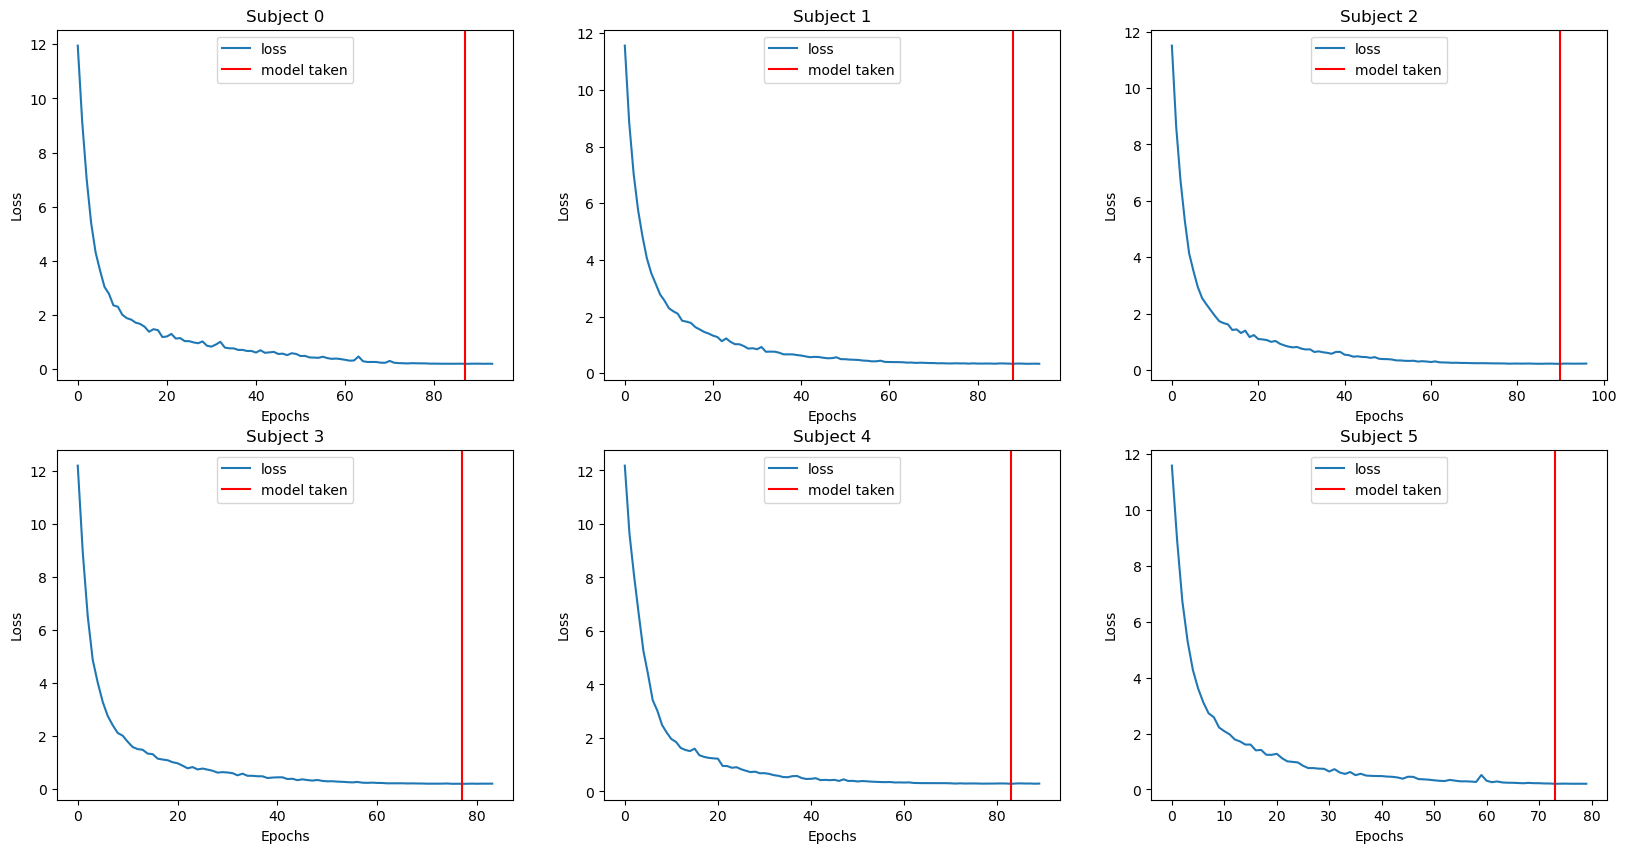

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(losses)):
    axes[i].plot(losses[i], label = "loss")
    axes[i].set_title(f"Subject {i}")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")
    axes[i].axvline(x = np.argmin(losses[i]), label = "model taken", color = "red")
    axes[i].legend()

In [17]:
from sklearn.manifold import TSNE

with open("finetune_data.pkl", "rb") as f:
    finetune_data = pickle.load(f)
with open("finetune_labels.pkl", "rb") as f:
    finetune_labels = pickle.load(f)
with open("encoder.pkl", "rb") as f:
    one_hot_encoder = pickle.load(f)

features_reduced_list = {}
for subject in tqdm(range(len(finetune_data))):
    subject_model = tf.keras.models.load_model(model_path + f"simclr_model_{subject}")
    encoder = Model(inputs=subject_model.inputs, outputs=subject_model.get_layer("encoder_output").output)

    #getting embeddings from finetune_data[subject] because pre_text task of subject i is trained on train_data (all devices except i), so it is a good test set
    embeddings = encoder.predict(finetune_data[subject], verbose = 0)
    labels = one_hot_encoder.inverse_transform(finetune_labels[subject]).reshape(-1)
    
    features_reduced_list[subject] = [TSNE(n_components= 2, perplexity=30, verbose=0, random_state=42).fit_transform(embeddings), labels]


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


In [18]:
#dump features_reduced_list
with open("features_reduced_list.pkl", "wb") as f:
    pickle.dump(features_reduced_list, f)

### Visualizing latent vectors space generated on the downstream dataset

In [7]:
features_reduced_list = pickle.load(open("features_reduced_list.pkl", "rb"))

In [8]:
#disabling info messages for a more clear training visualization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0: all messages are logged, 1: filter out INFO messages, 2: filter out INFO and WARNING messages, 3: filter out INFO, WARNING, and ERROR messages

In [9]:
#load pretext data
import pickle
with open('finetune_data.pkl', 'rb') as f:
    finetune_data = pickle.load(f)
with open('finetune_labels.pkl', 'rb') as f:
    finetune_labels = pickle.load(f)

with open('encoder.pkl', 'rb') as f:
    one_hot_encoder = pickle.load(f)

In [10]:
from sklearn.manifold import TSNE
import seaborn as sns
from ipywidgets import interact, fixed

def plot_simclr_features(features_reduced_list, subject):
    features_reduced = features_reduced_list[subject][0]
    labels = features_reduced_list[subject][1]

    sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue = labels, palette = "bright")
    plt.show()

interact(plot_simclr_features, features_reduced_list = fixed(features_reduced_list), subject = (0, len(finetune_data) - 1))

interactive(children=(IntSlider(value=2, description='subject', max=5), Output()), _dom_classes=('widget-inter…

<function __main__.plot_simclr_features(features_reduced_list, subject)>

# Finetuning

In [62]:
#disabling info messages for a more clear training visualization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0: all messages are logged, 1: filter out INFO messages, 2: filter out INFO and WARNING messages, 3: filter out INFO, WARNING, and ERROR messages

In [63]:
import pickle
with open("finetune_data.pkl", "rb") as f:
    finetune_data = pickle.load(f)
with open("finetune_labels.pkl", "rb") as f:
    finetune_labels = pickle.load(f)

In [147]:
from keras.layers import Dense
from keras import regularizers
from keras.models import Model
import tensorflow as tf

def full_model(sim_clr_model, num_classes, weight_decay = 5e-4): #before 1e-4
    for layer in sim_clr_model.layers:
        layer.trainable = False
            
    input = sim_clr_model.input

    x = sim_clr_model.get_layer("encoder_output").output
    
    #x = Dense(256, activation='relu', kernel_regularizer = regularizers.L1(weight_decay))(x)
    #x = Dense(128, activation='relu', kernel_regularizer = regularizers.L1(weight_decay))(x)
    #x = Dense(1024, activation='relu', kernel_regularizer = regularizers.L1(weight_decay))(x)
    x = Dense(1024, activation='relu', kernel_regularizer = regularizers.L1(weight_decay))(x)
    p = Dense(num_classes, activation='softmax')(x)

    return Model(inputs = input, outputs = p)

In [148]:
encoder_model = tf.keras.models.load_model(model_path + f"simclr_model_{0}")
classifier = full_model(encoder_model, 6)
classifier.summary()

Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400, 12)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 385, 24)           4632      
                                                                 
 batch_normalization_3 (Bat  (None, 385, 24)           96        
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 370, 32)           12320     
                                                                 
 batch_normalization_4 (Bat  (None, 370, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 363, 64)           16

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf

model_path = "models/"
train_loss = {}
train_acc = {}
val_loss = {}
val_acc = {}

results = {}
patience = 10
epochs = 1000
batch_size = 64
lr = 0.00005
decay_steps = 2000

for proportion in tqdm([0.1, 0.25, 0.5]):
    for subject in range(len(finetune_data)):
        X_train = np.concatenate([finetune_data[i] for i in range(len(finetune_data)) if i != subject])
        y_train = np.concatenate([finetune_labels[i] for i in range(len(finetune_data)) if i != subject])

        #shuffle train data and take only the proportion of it
        X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size = 1 - proportion, random_state = 42)

        X_test = finetune_data[subject]
        y_test = finetune_labels[subject]

        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='auto', restore_best_weights=True)
        encoder = tf.keras.models.load_model(model_path + f"simclr_model_{subject}")
        model = full_model(encoder, num_classes=6)

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr)
        model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

        history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], shuffle=True)
        model.save(model_path + f"simclr_classifier_{subject}_{proportion}")

        #keeping trak of the metrics
        train_loss[subject] = history.history['loss']
        train_acc[subject] = history.history['accuracy']
        val_loss[subject] = history.history['val_loss']
        val_acc[subject] = history.history['val_accuracy']

        #Predict the test 
        y_pred = model.predict(X_test, verbose=0)

        # Compute precision, recall, and F1 score
        precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')
        recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')
        f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average = 'macro')

        results[subject] = [precision, recall, f1]

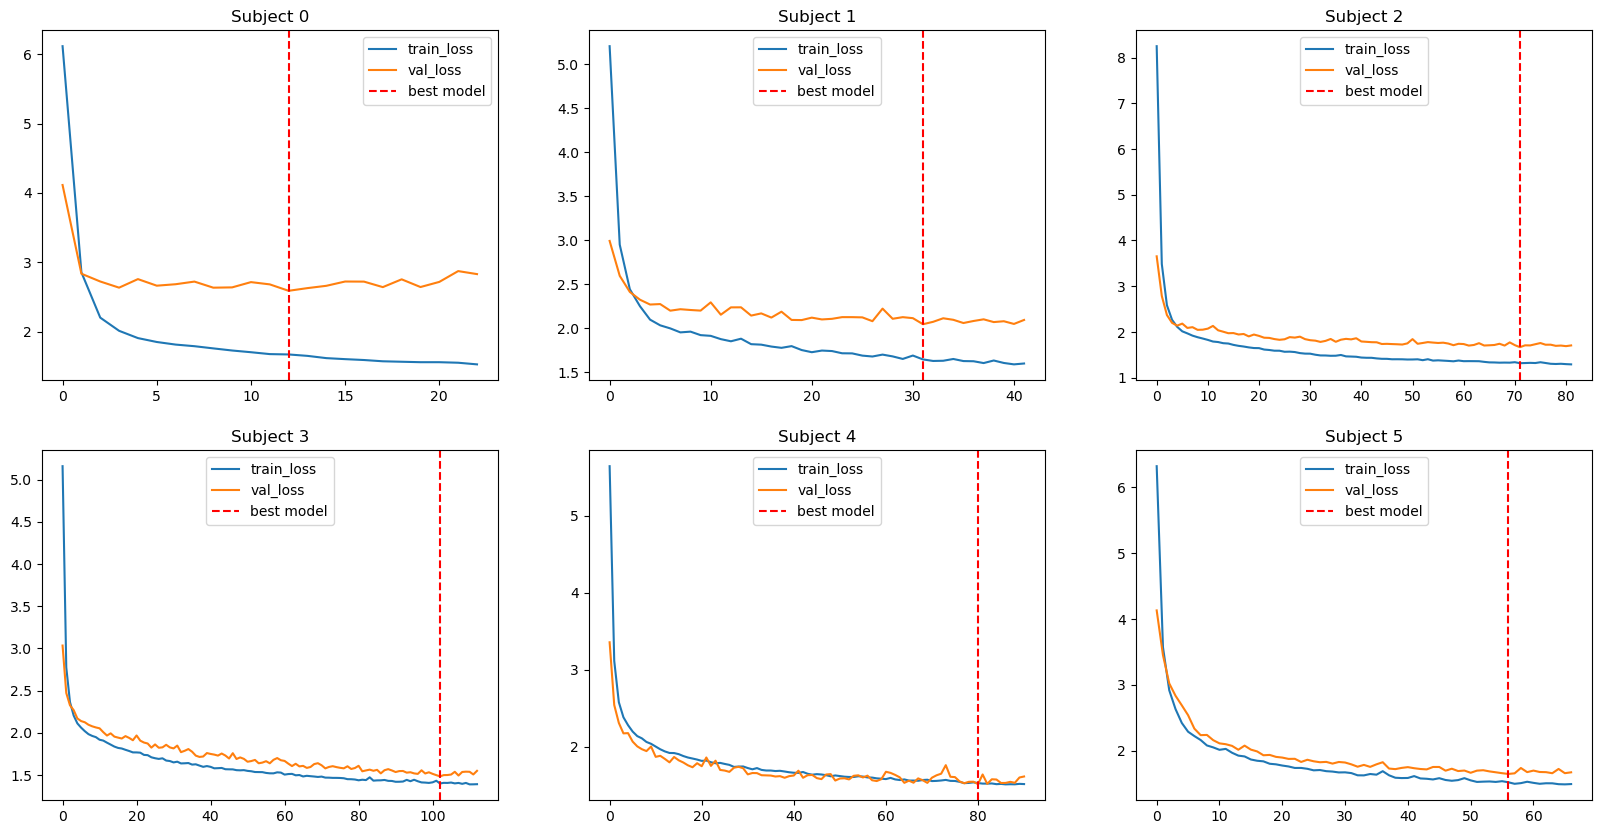

In [151]:
#just plotting last model losses (50% of data)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(axes)):
    axes[i].plot(train_loss[i], label = "train_loss")
    axes[i].plot(val_loss[i], label = "val_loss")
    axes[i].axvline(np.argmin(val_loss[i]), linestyle = "--", color = "r", label = "best model")
    axes[i].set_title(f"Subject {i}")
    axes[i].legend()

# Performance comparison

In [18]:
import tensorflow as tf
import pickle
import numpy as np
#loading finetune_data
model_path = "models/"
finetune_data = pickle.load(open("finetune_data.pkl", "rb"))
finetune_labels = pickle.load(open("finetune_labels.pkl", "rb"))
one_hot_encoder = pickle.load(open("encoder.pkl", "rb"))
subject_number = len(finetune_data)

#loading the baseline models
baseline_models = [tf.keras.models.load_model(model_path + f"baseline_model_{i}") for i in range(subject_number)]

#loading the simclr models
tuned_models_10 = [tf.keras.models.load_model(model_path + f"simclr_classifier_{i}_0.1") for i in range(subject_number)]
tuned_models_25 = [tf.keras.models.load_model(model_path + f"simclr_classifier_{i}_0.25") for i in range(subject_number)]
tuned_models_50 = [tf.keras.models.load_model(model_path + f"simclr_classifier_{i}_0.5") for i in range(subject_number)]


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

results_baseline = {}
results_tuned_10 = {}
results_tuned_25 = {}
results_tuned_50 = {}

conf_matrices_baseline = {}

conf_matrices_finetuned_10 = {}
conf_matrices_finetuned_25 = {}
conf_matrices_finetuned_50 = {}


subject_number = len(finetune_data)

for i in range(subject_number):
    X_test = finetune_data[i]
    y_test = finetune_labels[i]
    #taking test data and lefting out the one used for validation with same random state 
    X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

    y_pred = baseline_models[i].predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    f1 = f1_score(y_true, y_pred, average = 'macro')

    results_baseline[i] = [precision, recall, f1]
    conf_matrices_baseline[i] = confusion_matrix(y_true, y_pred)

    y_pred = tuned_models_10[i].predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    f1 = f1_score(y_true, y_pred,  average = 'macro')

    results_tuned_10[i] = [precision, recall, f1]
    conf_matrices_finetuned_10[i] = confusion_matrix(y_true, y_pred)

    y_pred = tuned_models_25[i].predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    f1 = f1_score(y_true, y_pred,  average = 'macro')

    results_tuned_25[i] = [precision, recall, f1]
    conf_matrices_finetuned_25[i] = confusion_matrix(y_true, y_pred)

    y_pred = tuned_models_50[i].predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average = 'macro')
    recall = recall_score(y_true, y_pred, average = 'macro')
    f1 = f1_score(y_true, y_pred,  average = 'macro')

    results_tuned_50[i] = [precision, recall, f1]
    conf_matrices_finetuned_50[i] = confusion_matrix(y_true, y_pred)


2023-11-29 13:05:36.454353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:38.783849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:41.152773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:43.657911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:45.943664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:48.251292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 13:05:50.716714: I tensorflow/core/grappler/optimizers/cust

## Confusion matrices of baseline Model and SimCLR finetuned model with 50% of labeled data
The following plot represent the aggregate confusion matrices of the above indicated models. I find more useful to aggregate confusion matrices instead of evaluating one confusion matrix for each subject for each model.

In [20]:
from sklearn.preprocessing import normalize as norm

def aggregate_conf_matrices(conf_matrices: dict, normalize = True):
    num_classes = list(conf_matrices.values())[0].shape[0]
    aggregated_mat = np.zeros((num_classes, num_classes))
    for mat in conf_matrices.values():
        aggregated_mat += mat
    
    if normalize:
        #normalize by rows enhances more the distribution of predicted labels
        aggregated_mat = norm(aggregated_mat, axis = 1, norm = 'l1')

    return aggregated_mat

In [21]:
one_hot_encoder = pickle.load(open("encoder.pkl", "rb"))

Text(0.5, 25.722222222222214, 'Predicted label')

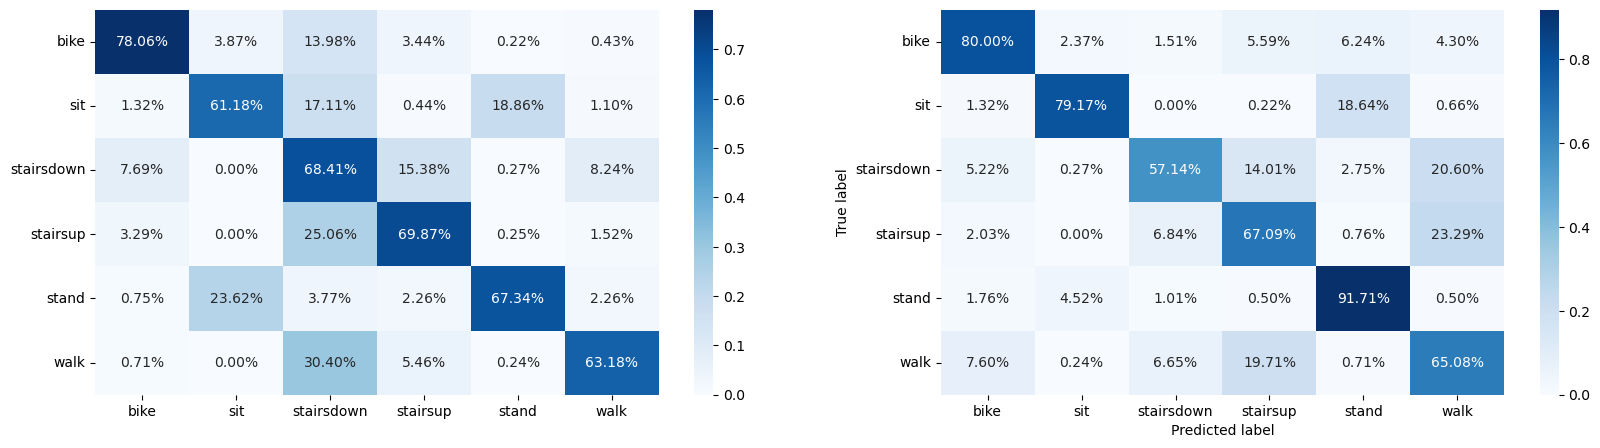

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
baseline_conf_matrix = aggregate_conf_matrices(conf_matrices_baseline, True)
tuned_conf_matrix = aggregate_conf_matrices(conf_matrices_finetuned_50, True)

activities = one_hot_encoder.categories_[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

sns.heatmap(baseline_conf_matrix, ax=ax1, annot=True, fmt='.2%', cmap='Blues', xticklabels = activities, yticklabels = activities)
sns.heatmap(tuned_conf_matrix, ax = ax2, annot=True, fmt='.2%', cmap='Blues', xticklabels = activities, yticklabels = activities)
plt.ylabel('True label')
plt.xlabel('Predicted label')

As we can notice (and as expected) the most uncertain predictions are related to stairsdown, stairsup and walk, three very similar activities

In [23]:
conf_baseline = aggregate_conf_matrices(conf_matrices_baseline, True)
conf_tuned_10 = aggregate_conf_matrices(conf_matrices_finetuned_10, True)
conf_tuned_25 = aggregate_conf_matrices(conf_matrices_finetuned_25, True)
conf_tuned_50 = aggregate_conf_matrices(conf_matrices_finetuned_50, True)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP

        precision[i] = TP / (TP + FP)
        recall[i] = TP / (TP + FN)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    return precision, recall, f1



In [25]:
precision, recall, f1 = calculate_metrics(conf_baseline)
baseline_results = [np.mean(precision), np.mean(recall), np.mean(f1)]

precision, recall, f1 = calculate_metrics(conf_tuned_10)
tuned_results_10 = [np.mean(precision), np.mean(recall), np.mean(f1)]

precision, recall, f1 = calculate_metrics(conf_tuned_25)
tuned_results_25 = [np.mean(precision), np.mean(recall), np.mean(f1)]

precision, recall, f1 = calculate_metrics(conf_tuned_50)
tuned_results_50 = [np.mean(precision), np.mean(recall), np.mean(f1)]

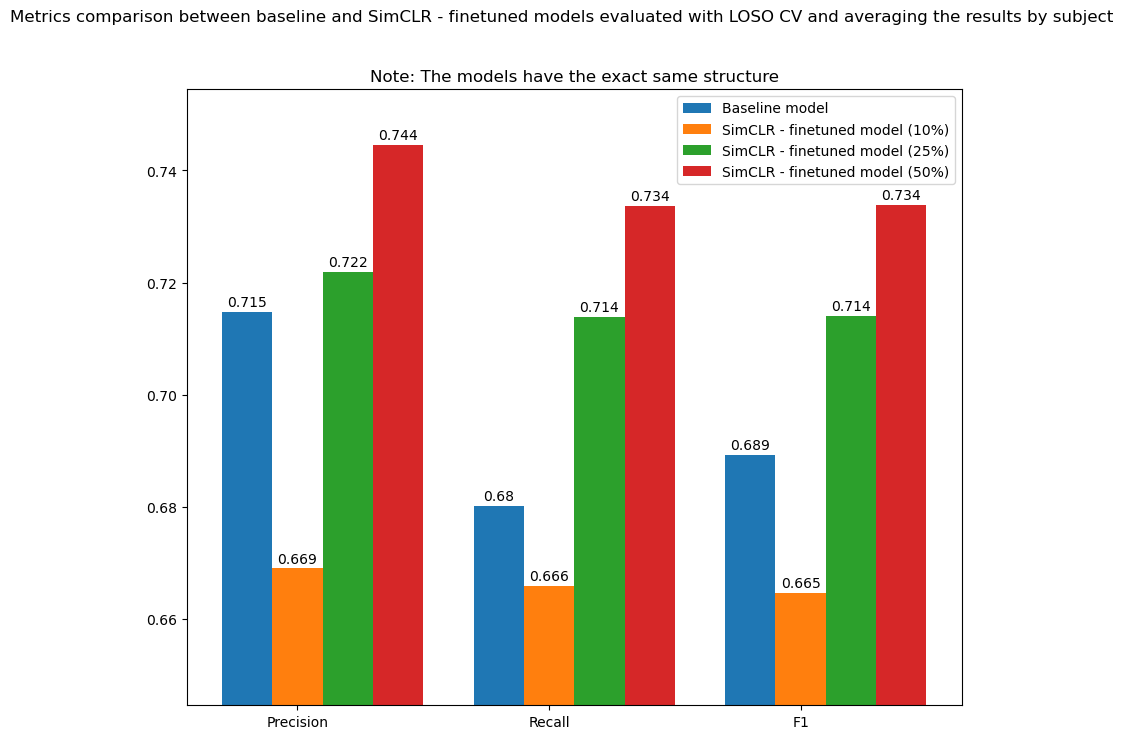

In [26]:
fig, ax = plt.subplots(figsize = (10, 8))
x = np.arange(3)
width = 0.20

#put values on top of the relative bar and center them
for i in range(len(baseline_results)):
    ax.text(x[i] - width, baseline_results[i] + 0.001, round(baseline_results[i], 3), ha = "center")
    ax.text(x[i], tuned_results_10[i]+ 0.001, round(tuned_results_10[i], 3), ha = "center")
    ax.text(x[i] + width, tuned_results_25[i]+ 0.001, round(tuned_results_25[i], 3), ha = "center")
    ax.text(x[i] + 2*width, tuned_results_50[i]+ 0.001, round(tuned_results_50[i], 3), ha = "center")

down_lim = min(min(baseline_results, tuned_results_10, tuned_results_25, tuned_results_50)) - 0.02
up_lim =  max(max(baseline_results, tuned_results_10, tuned_results_25, tuned_results_50)) + 0.01

ax.bar(x - width, baseline_results, width, label = "Baseline model")
ax.bar(x, tuned_results_10, width, label = "SimCLR - finetuned model (10%)")
ax.bar(x + width, tuned_results_25, width, label = "SimCLR - finetuned model (25%)")
ax.bar(x + 2*width, tuned_results_50, width, label = "SimCLR - finetuned model (50%)")

ax.set_xticks(x)
ax.set_xticklabels(["Precision", "Recall", "F1"])
ax.set_ylim(down_lim, up_lim)
fig.suptitle("Metrics comparison between baseline and SimCLR - finetuned models evaluated with LOSO CV and averaging the results by subject")
ax.set_title("Note: The models have the exact same structure")

ax.legend()
plt.show()